#### Importing required packages

In [ ]:
# Core
import os
import glob
import pickle

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from scipy.stats import zscore


# Time series
from statsmodels.tsa.seasonal import seasonal_decompose, STL
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA

# ML
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from xgboost import XGBRegressor


# DL
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, GlobalAveragePooling1D
from tensorflow.keras.layers import LSTM, Dense, Dropout, LayerNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Attention, Input
from tensorflow.keras.models import Model

# Utils
import warnings
warnings.filterwarnings("ignore")


In [8]:
input_dir = "../data/"


In [9]:
# List to store dataframes
all_coins = []
# Iterate through all csv files in the directory
files = glob.glob(os.path.join(input_dir, "coin_*.csv"))
for filepath in files:
    try:
        # Read the file
        df_temp = pd.read_csv(filepath)
        # Extract coin name from filename if not in columns, or strictly use filename
        coin_name = os.path.basename(filepath).split('_')[1].split('.')[0]
        # Ensure we have a column for the coin name to distinguish after merging
        df_temp['Coin_Name'] = coin_name
        all_coins.append(df_temp)
    except Exception as e:
        print(f"Error reading {filepath}: {e}")


#### Load the Datasets
Here, I used BitCoin dataset

In [10]:
# Concatenate all into one master dataframe
# df = pd.concat(all_coins, axis=0, ignore_index=True)
df = pd.read_csv("../data/coin_Bitcoin.csv")


In [11]:
print(f"Total Rows: {df.shape[0]}")
print(f"Total Columns: {df.shape[1]}")
# print(f"Unique Coins: {df['Coin_Name'].nunique()}")


Total Rows: 2991
Total Columns: 10


## Data Understanding & EDA Requirements

In [12]:
df.dtypes


SNo            int64
Name          object
Symbol        object
Date          object
High         float64
Low          float64
Open         float64
Close        float64
Volume       float64
Marketcap    float64
dtype: object

In [13]:
# Convert Date to datetime object
df['Date'] = pd.to_datetime(df['Date'])
df.dtypes


SNo                   int64
Name                 object
Symbol               object
Date         datetime64[ns]
High                float64
Low                 float64
Open                float64
Close               float64
Volume              float64
Marketcap           float64
dtype: object

In [14]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2991 entries, 0 to 2990
Data columns (total 10 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   SNo        2991 non-null   int64         
 1   Name       2991 non-null   object        
 2   Symbol     2991 non-null   object        
 3   Date       2991 non-null   datetime64[ns]
 4   High       2991 non-null   float64       
 5   Low        2991 non-null   float64       
 6   Open       2991 non-null   float64       
 7   Close      2991 non-null   float64       
 8   Volume     2991 non-null   float64       
 9   Marketcap  2991 non-null   float64       
dtypes: datetime64[ns](1), float64(6), int64(1), object(2)
memory usage: 233.8+ KB


### Plot for Close Price history

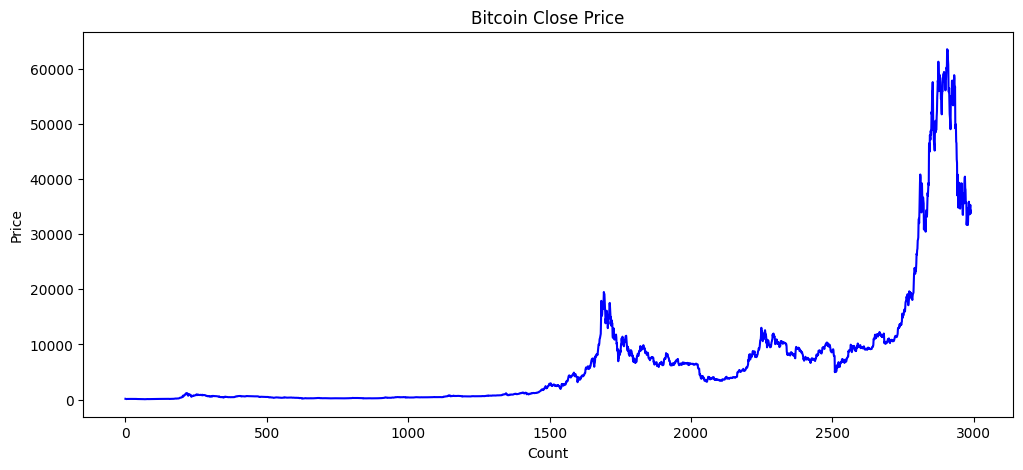

In [15]:
plt.figure(figsize=(12,5))
plt.plot(df['Close'], color='blue')
plt.title("Bitcoin Close Price")
plt.xlabel("Count")
plt.ylabel("Price")
plt.show()


#### Identifying Trend

In [16]:
df['MA_7']  = df['Close'].rolling(window=7).mean()
df['MA_15'] = df['Close'].rolling(window=15).mean()
df['MA_30'] = df['Close'].rolling(window=30).mean()
df.head(40)


,SNo,Name,Symbol,Date,High,Low,Open,Close,Volume,Marketcap,MA_7,MA_15,MA_30
0,1,Bitcoin,BTC,2013-04-29 23:59:59,147.488007,134.000000,134.444000,144.539993,0.0,1.603769e+09,NaN,NaN,NaN
1,2,Bitcoin,BTC,2013-04-30 23:59:59,146.929993,134.050003,144.000000,139.000000,0.0,1.542813e+09,NaN,NaN,NaN
2,3,Bitcoin,BTC,2013-05-01 23:59:59,139.889999,107.720001,139.000000,116.989998,0.0,1.298955e+09,NaN,NaN,NaN
3,4,Bitcoin,BTC,2013-05-02 23:59:59,125.599998,92.281898,116.379997,105.209999,0.0,1.168517e+09,NaN,NaN,NaN
4,5,Bitcoin,BTC,2013-05-03 23:59:59,108.127998,79.099998,106.250000,97.750000,0.0,1.085995e+09,NaN,NaN,NaN
5,6,Bitcoin,BTC,2013-05-04 23:59:59,115.000000,92.500000,98.099998,112.500000,0.0,1.250317e+09,NaN,NaN,NaN
6,7,Bitcoin,BTC,2013-05-05 23:59:59,118.800003,107.142998,112.900002,115.910004,0.0,1.288693e+09,118.842856,NaN,NaN
7,8,Bitcoin,BTC,2013-05-06 23:59:59,124.663002,106.639999,115.980003,112.300003,0.0,1.249023e+09,114.237143,NaN,NaN
8,9,Bitcoin,BTC,2013-05-07 23:59:59,113.444000,97.699997,112.250000,111.500000,0.0,1.240594e+09,110.308572,NaN,NaN
9,10,Bitcoin,BTC,2013-05-08 23:59:59,115.779999,109.599998,109.599998,113.566002,0.0,1.264049e+09,109.819430,NaN,NaN


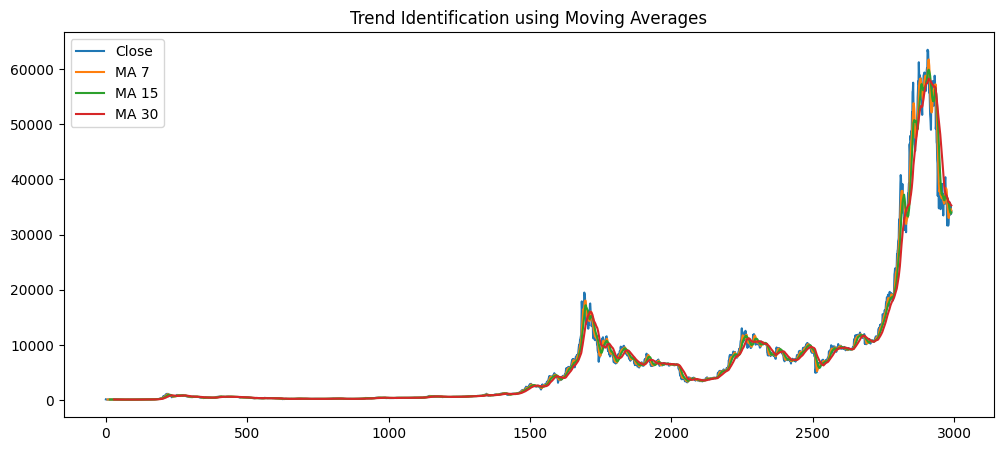

In [17]:
plt.figure(figsize=(12,5))
plt.plot(df['Close'], label='Close')
plt.plot(df['MA_7'], label='MA 7')
plt.plot(df['MA_15'], label='MA 15')
plt.plot(df['MA_30'], label='MA 30')
plt.legend()
plt.title("Trend Identification using Moving Averages")
plt.show()


#### Seasonality identification

In [18]:
stl = STL(df['Close'], period=7)  # weekly seasonality
result = stl.fit()


In [19]:
df['Trend'] = result.trend
df['Seasonal'] = result.seasonal
df['Residual'] = result.resid


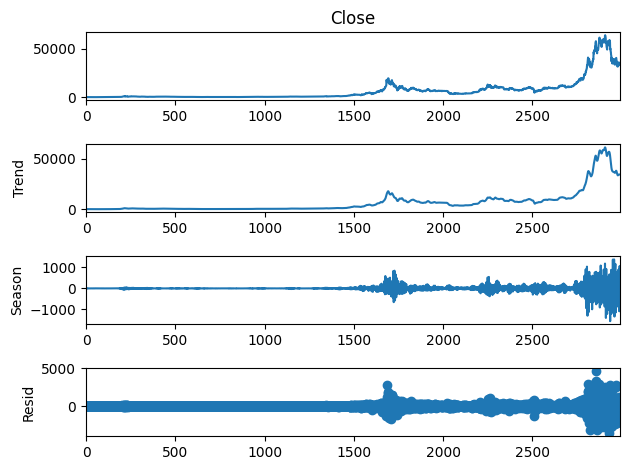

In [20]:
result.plot()
plt.show()


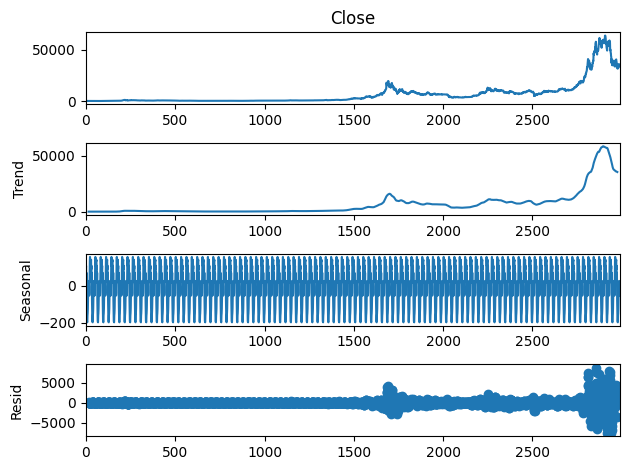

In [21]:
decomp = seasonal_decompose(df['Close'], model='additive', period=30)
decomp.plot()
plt.show()


#### Volatility Identification

In [22]:
## Log return
df['log_return'] = np.log(df['Close'] / df['Close'].shift(1))


In [23]:
## Roling volatility
df['volatility_7']  = df['log_return'].rolling(7).std()
df['volatility_15'] = df['log_return'].rolling(15).std()
df['volatility_30'] = df['log_return'].rolling(30).std()


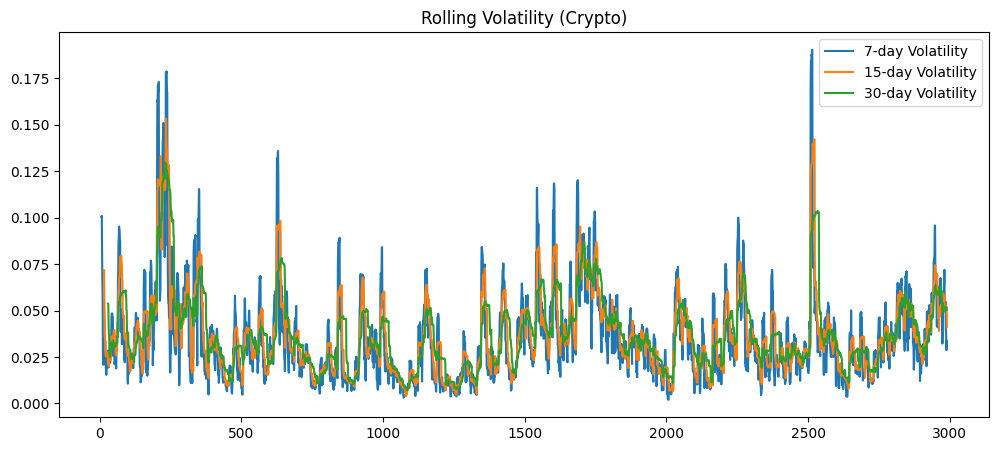

In [24]:
plt.figure(figsize=(12,5))
plt.plot(df['volatility_7'], label='7-day Volatility')
plt.plot(df['volatility_15'], label='15-day Volatility')
plt.plot(df['volatility_30'], label='30-day Volatility')

plt.legend()
plt.title("Rolling Volatility (Crypto)")
plt.show()


In [25]:
## Volatility Regimes
vol_threshold = df['volatility_30'].quantile(0.75)

df['volatility_regime_30'] = np.where(df['volatility_30'] > vol_threshold,'High Volatility','Low Volatility')


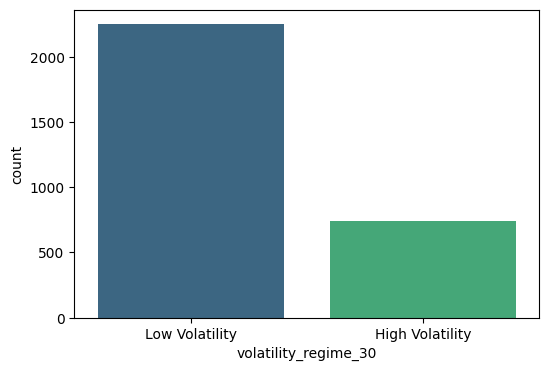

In [26]:
plt.figure(figsize=(6,4))
sns.countplot(x = "volatility_regime_30", data = df, palette='viridis')
plt.show()


In [27]:
df


,SNo,Name,Symbol,Date,High,Low,Open,Close,Volume,Marketcap,...,MA_15,MA_30,Trend,Seasonal,Residual,log_return,volatility_7,volatility_15,volatility_30,volatility_regime_30
0,1,Bitcoin,BTC,2013-04-29 23:59:59,147.488007,134.000000,134.444000,144.539993,0.000000e+00,1.603769e+09,...,NaN,NaN,124.513648,13.510565,6.515781,NaN,NaN,NaN,NaN,Low Volatility
1,2,Bitcoin,BTC,2013-04-30 23:59:59,146.929993,134.050003,144.000000,139.000000,0.000000e+00,1.542813e+09,...,NaN,NaN,122.352521,9.877990,6.769489,-0.039082,NaN,NaN,NaN,Low Volatility
2,3,Bitcoin,BTC,2013-05-01 23:59:59,139.889999,107.720001,139.000000,116.989998,0.000000e+00,1.298955e+09,...,NaN,NaN,120.357377,-2.213524,-1.153856,-0.172385,NaN,NaN,NaN,Low Volatility
3,4,Bitcoin,BTC,2013-05-02 23:59:59,125.599998,92.281898,116.379997,105.209999,0.000000e+00,1.168517e+09,...,NaN,NaN,118.507575,-8.172636,-5.124941,-0.106130,NaN,NaN,NaN,Low Volatility
4,5,Bitcoin,BTC,2013-05-03 23:59:59,108.127998,79.099998,106.250000,97.750000,0.000000e+00,1.085995e+09,...,NaN,NaN,116.770600,-9.894992,-9.125608,-0.073545,NaN,NaN,NaN,Low Volatility
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2986,2987,Bitcoin,BTC,2021-07-02 23:59:59,33939.588699,32770.680780,33549.600177,33897.048590,3.872897e+10,6.354508e+11,...,34063.669852,35618.790261,34332.563133,-1095.522467,660.007923,0.009632,0.039215,0.052242,0.051774,High Volatility
2987,2988,Bitcoin,BTC,2021-07-03 23:59:59,34909.259899,33402.696536,33854.421362,34668.548402,2.438396e+10,6.499397e+11,...,33989.090093,35467.449674,34335.445545,-130.190373,463.293229,0.022505,0.039432,0.050547,0.051287,High Volatility
2988,2989,Bitcoin,BTC,2021-07-04 23:59:59,35937.567147,34396.477458,34665.564866,35287.779766,2.492431e+10,6.615748e+11,...,33967.217460,35413.895489,34327.893632,1070.089444,-110.203309,0.017704,0.028708,0.050795,0.050286,High Volatility
2989,2990,Bitcoin,BTC,2021-07-05 23:59:59,35284.344430,33213.661034,35284.344430,33746.002456,2.672155e+10,6.326962e+11,...,33837.064527,35353.696946,34308.663792,-446.144558,-116.516778,-0.044675,0.033890,0.052035,0.050490,High Volatility


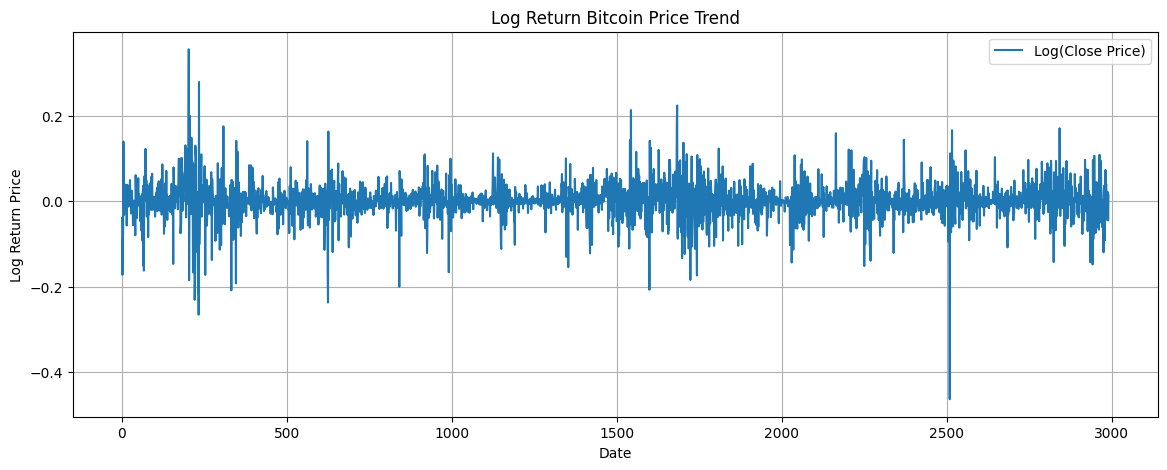

In [28]:
plt.figure(figsize=(14,5))
plt.plot(df['log_return'], label='Log(Close Price)')
plt.title('Log Return Bitcoin Price Trend')
plt.xlabel('Date')
plt.ylabel('Log Return Price')
plt.legend()
plt.grid(True)
plt.show()


B. ACF Plots (Seasonality Checks)

<Figure size 1000x300 with 0 Axes>

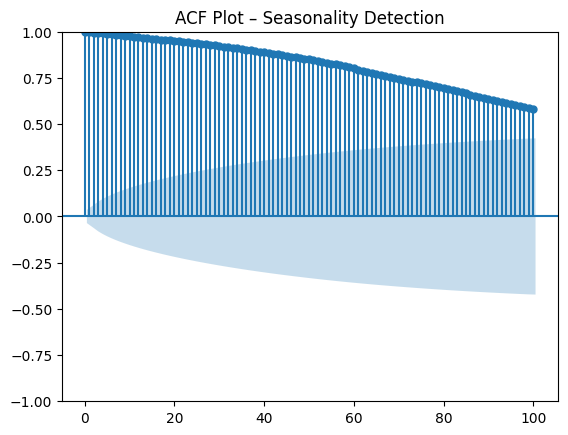

In [29]:
plt.figure(figsize=(10,3))
plot_acf(df['Close'], lags=100, )
plt.title('ACF Plot – Seasonality Detection')
plt.show()


What to look for:
- Absence of strong spikes at fixed intervals (7, 30, 365)
- Confirms weak seasonality

##### Perform ADF Test for Stationarity

In [30]:
adf_test = adfuller(df['Close'])
print("ADF Statistic:", adf_test[0])
print("p-value:", adf_test[1])
print("Critical Values:")
for key, value in adf_test[4].items():
    print(f"   {key}: {value}")


ADF Statistic: -0.7973098451195634
p-value: 0.8199110033239144
Critical Values:
   1%: -3.4325603944919445
   5%: -2.8625166073924957
   10%: -2.567289874591689


##### Plot ACF & PACF for Lag Relationships

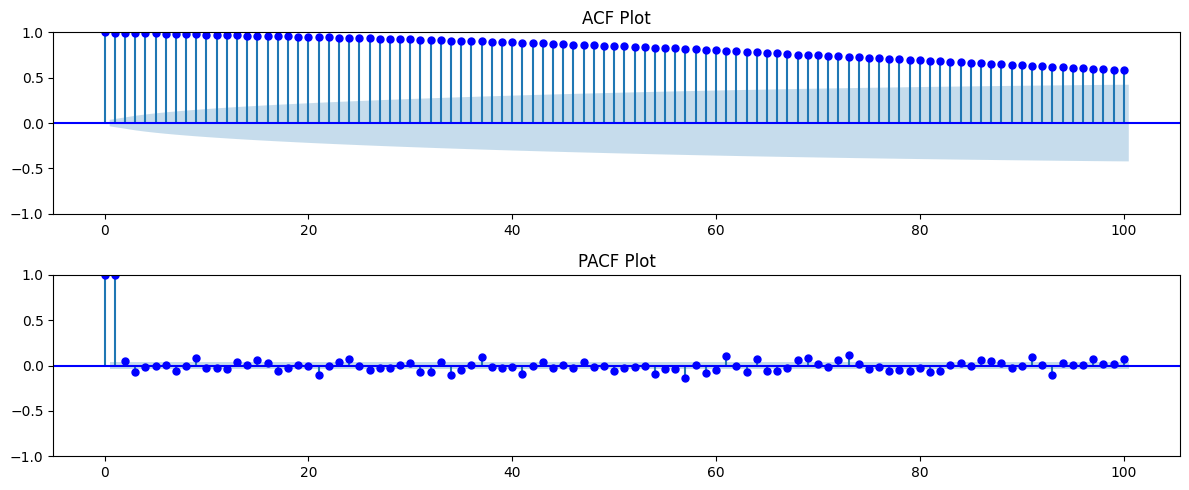

In [31]:
fig, axes = plt.subplots(2, 1, figsize=(12,5))
plot_acf(df['Close'], lags=100, ax=axes[0], color = 'blue')
plot_pacf(df['Close'], lags=100, ax=axes[1], color = 'blue')
axes[0].set_title("ACF Plot")
axes[1].set_title("PACF Plot")
plt.tight_layout()
plt.show()


##### Plot Moving Averages

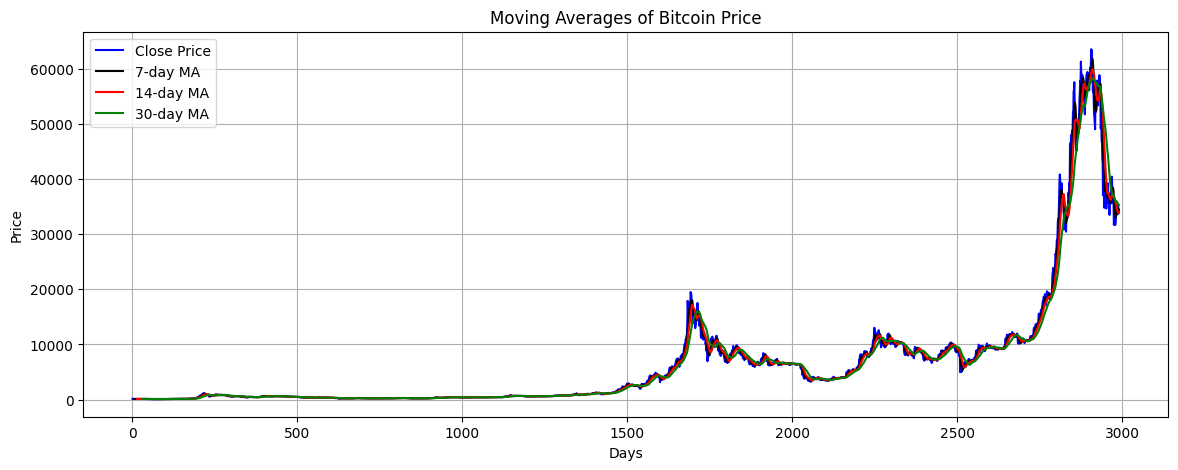

In [32]:
plt.figure(figsize=(14,5))
plt.plot(df['Close'], label='Close Price', color='blue')
plt.plot(df['MA_7'], label='7-day MA', color = 'black')
plt.plot(df['MA_15'], label='14-day MA', color = 'red')
plt.plot(df["MA_30"], label='30-day MA', color = 'green')
plt.title("Moving Averages of Bitcoin Price")
plt.xlabel("Days")
plt.ylabel("Price")
plt.legend()
plt.grid(True)
plt.show()


##### Investigate Correlation Between Volume and Price

Correlation values between features

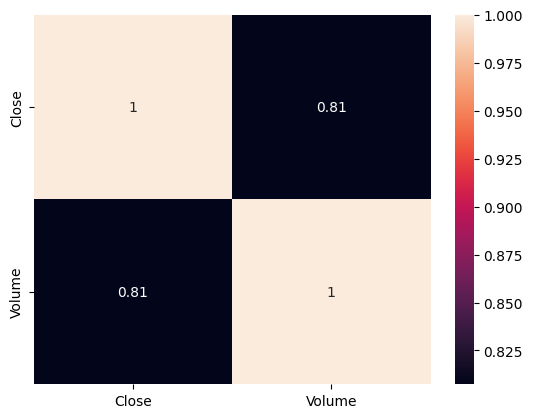

In [33]:
corr = df[['Close', 'Volume']].corr()
sns.heatmap(corr, annot = True, )
plt.show()


Scatter Plot

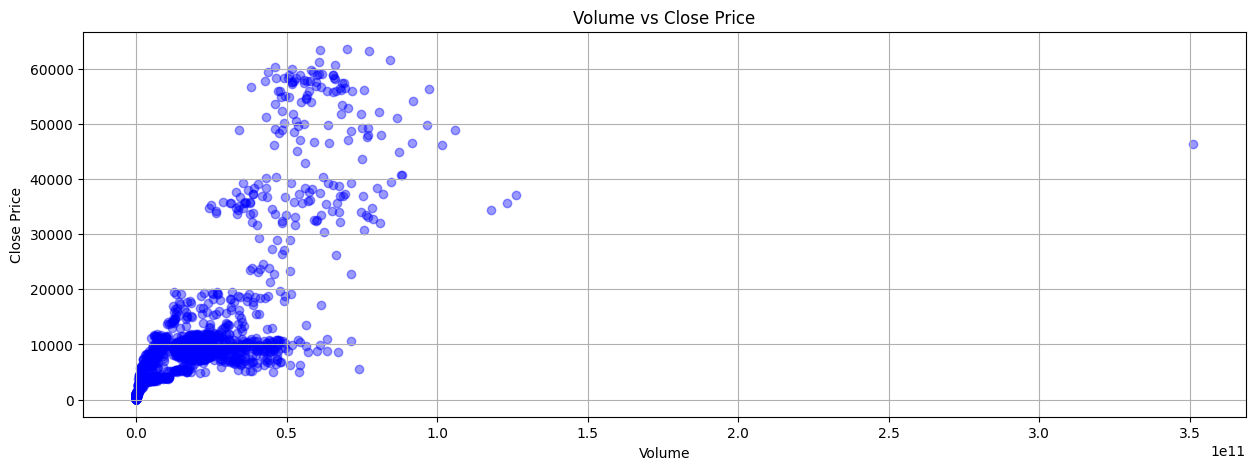

In [34]:
plt.figure(figsize=(15, 5))
plt.scatter(df['Volume'], df['Close'], alpha=0.4, color = 'blue')
plt.title("Volume vs Close Price")
plt.xlabel("Volume")
plt.ylabel("Close Price")
plt.grid(True)
plt.show()


##### Detect Anomalies / Outliers

##### Price Distribution

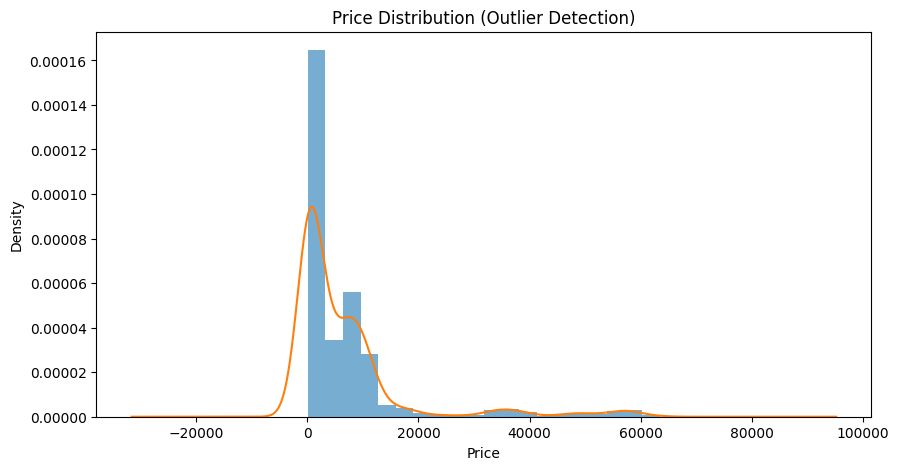

In [35]:
plt.figure(figsize=(10,5))
plt.hist(df['Close'], bins=20, density=True, alpha=0.6)
df['Close'].plot(kind='kde')
plt.title("Price Distribution (Outlier Detection)")
plt.xlabel("Price")
plt.show()


##### Log Return Distribution

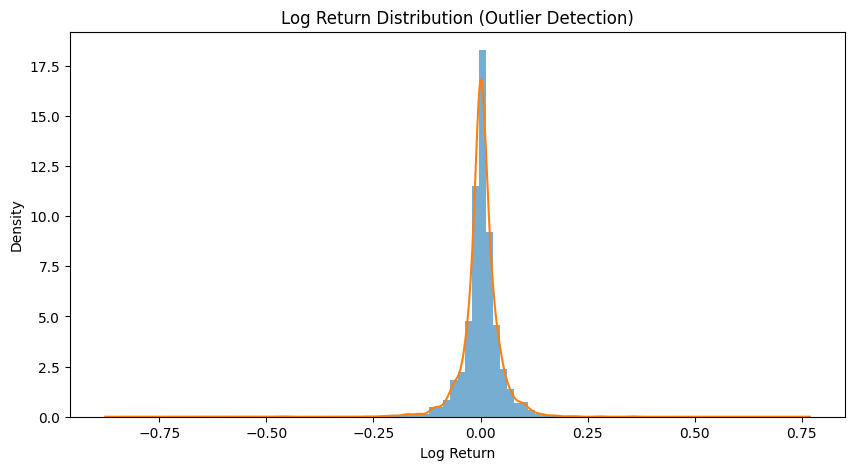

In [36]:
plt.figure(figsize=(10,5))
plt.hist(df['log_return'].dropna(), bins=50, density=True, alpha=0.6)
df['log_return'].dropna().plot(kind='kde')
plt.title("Log Return Distribution (Outlier Detection)")
plt.xlabel("Log Return")
plt.show()


##### Box Plot

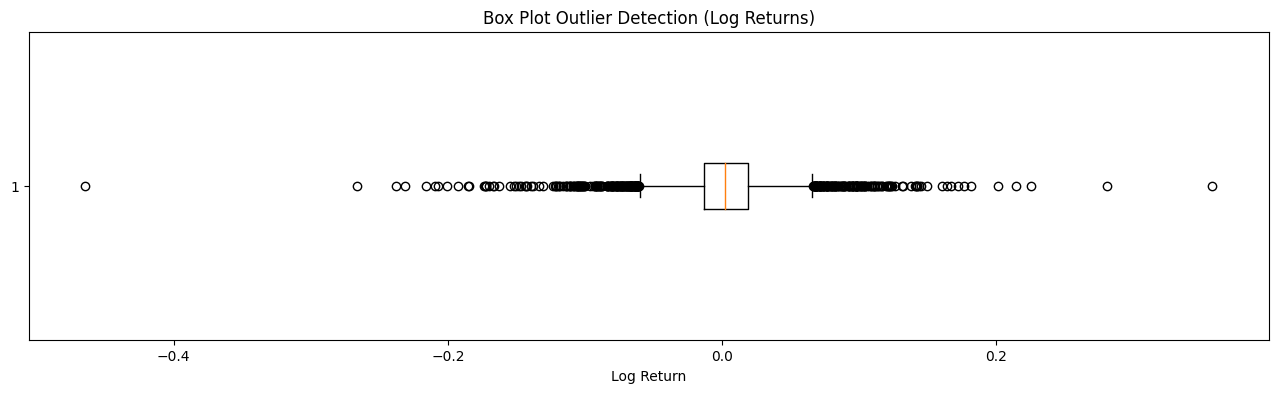

In [37]:
plt.figure(figsize=(16,4))
plt.boxplot(df['log_return'].dropna(), vert=False)
plt.title("Box Plot Outlier Detection (Log Returns)")
plt.xlabel("Log Return")
plt.show()


Points beyond whiskers = outliers

Useful for quick sanity checks

##### IQR-based Outlier Thresholds (Visual + Numeric)

In [38]:
Q1 = df['log_return'].quantile(0.25)
Q3 = df['log_return'].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

outliers = df[(df['log_return'] < lower_bound) | (df['log_return'] > upper_bound)]


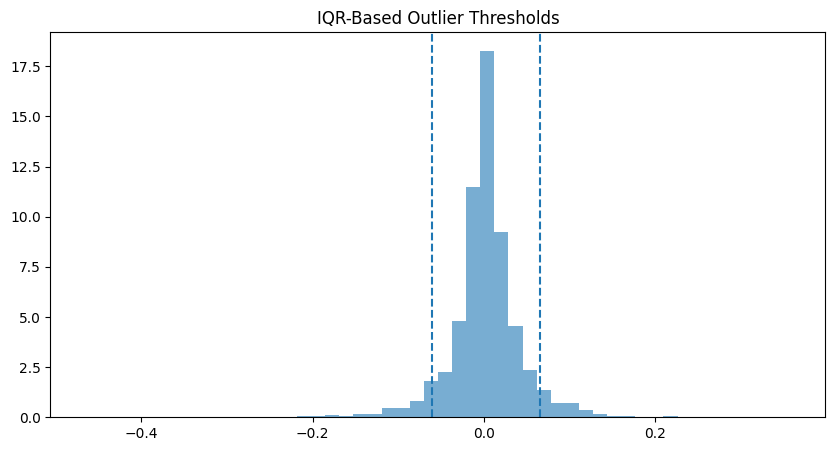

In [39]:
## Visualize bounds on distribution
plt.figure(figsize=(10,5))
plt.hist(df['log_return'].dropna(), bins=50, density=True, alpha=0.6)
plt.axvline(lower_bound, linestyle='--')
plt.axvline(upper_bound, linestyle='--')
plt.title("IQR-Based Outlier Thresholds")
plt.show()


##### Z-Score Distribution Plot

In [40]:
len(df['log_return'])


2991

In [41]:
df.isnull().sum()


SNo                      0
Name                     0
Symbol                   0
Date                     0
High                     0
Low                      0
Open                     0
Close                    0
Volume                   0
Marketcap                0
MA_7                     6
MA_15                   14
MA_30                   29
Trend                    0
Seasonal                 0
Residual                 0
log_return               1
volatility_7             7
volatility_15           15
volatility_30           30
volatility_regime_30     0
dtype: int64

In [42]:
df.head()


,SNo,Name,Symbol,Date,High,Low,Open,Close,Volume,Marketcap,...,MA_15,MA_30,Trend,Seasonal,Residual,log_return,volatility_7,volatility_15,volatility_30,volatility_regime_30
0,1,Bitcoin,BTC,2013-04-29 23:59:59,147.488007,134.000000,134.444000,144.539993,0.0,1.603769e+09,...,NaN,NaN,124.513648,13.510565,6.515781,NaN,NaN,NaN,NaN,Low Volatility
1,2,Bitcoin,BTC,2013-04-30 23:59:59,146.929993,134.050003,144.000000,139.000000,0.0,1.542813e+09,...,NaN,NaN,122.352521,9.877990,6.769489,-0.039082,NaN,NaN,NaN,Low Volatility
2,3,Bitcoin,BTC,2013-05-01 23:59:59,139.889999,107.720001,139.000000,116.989998,0.0,1.298955e+09,...,NaN,NaN,120.357377,-2.213524,-1.153856,-0.172385,NaN,NaN,NaN,Low Volatility
3,4,Bitcoin,BTC,2013-05-02 23:59:59,125.599998,92.281898,116.379997,105.209999,0.0,1.168517e+09,...,NaN,NaN,118.507575,-8.172636,-5.124941,-0.106130,NaN,NaN,NaN,Low Volatility
4,5,Bitcoin,BTC,2013-05-03 23:59:59,108.127998,79.099998,106.250000,97.750000,0.0,1.085995e+09,...,NaN,NaN,116.770600,-9.894992,-9.125608,-0.073545,NaN,NaN,NaN,Low Volatility


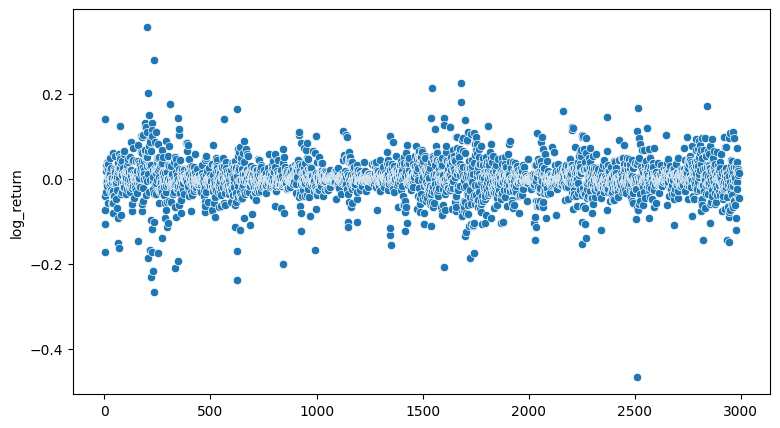

In [43]:
plt.figure(figsize = (9,5))
sns.scatterplot(df['log_return'])
plt.show()


In [44]:
df.dtypes


SNo                              int64
Name                            object
Symbol                          object
Date                    datetime64[ns]
High                           float64
Low                            float64
Open                           float64
Close                          float64
Volume                         float64
Marketcap                      float64
MA_7                           float64
MA_15                          float64
MA_30                          float64
Trend                          float64
Seasonal                       float64
Residual                       float64
log_return                     float64
volatility_7                   float64
volatility_15                  float64
volatility_30                  float64
volatility_regime_30            object
dtype: object

In [45]:
df1 = df.fillna(df.mean())


In [46]:
df1['z_score'] = zscore(df1['log_return'])
df1


,SNo,Name,Symbol,Date,High,Low,Open,Close,Volume,Marketcap,...,MA_30,Trend,Seasonal,Residual,log_return,volatility_7,volatility_15,volatility_30,volatility_regime_30,z_score
0,1,Bitcoin,BTC,2013-04-29 23:59:59,147.488007,134.000000,134.444000,144.539993,0.000000e+00,1.603769e+09,...,6606.573392,124.513648,13.510565,6.515781,0.001829,0.034614,0.036281,0.037536,Low Volatility,5.073006e-18
1,2,Bitcoin,BTC,2013-04-30 23:59:59,146.929993,134.050003,144.000000,139.000000,0.000000e+00,1.542813e+09,...,6606.573392,122.352521,9.877990,6.769489,-0.039082,0.034614,0.036281,0.037536,Low Volatility,-9.571148e-01
2,3,Bitcoin,BTC,2013-05-01 23:59:59,139.889999,107.720001,139.000000,116.989998,0.000000e+00,1.298955e+09,...,6606.573392,120.357377,-2.213524,-1.153856,-0.172385,0.034614,0.036281,0.037536,Low Volatility,-4.075758e+00
3,4,Bitcoin,BTC,2013-05-02 23:59:59,125.599998,92.281898,116.379997,105.209999,0.000000e+00,1.168517e+09,...,6606.573392,118.507575,-8.172636,-5.124941,-0.106130,0.034614,0.036281,0.037536,Low Volatility,-2.525705e+00
4,5,Bitcoin,BTC,2013-05-03 23:59:59,108.127998,79.099998,106.250000,97.750000,0.000000e+00,1.085995e+09,...,6606.573392,116.770600,-9.894992,-9.125608,-0.073545,0.034614,0.036281,0.037536,Low Volatility,-1.763377e+00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2986,2987,Bitcoin,BTC,2021-07-02 23:59:59,33939.588699,32770.680780,33549.600177,33897.048590,3.872897e+10,6.354508e+11,...,35618.790261,34332.563133,-1095.522467,660.007923,0.009632,0.039215,0.052242,0.051774,High Volatility,1.825632e-01
2987,2988,Bitcoin,BTC,2021-07-03 23:59:59,34909.259899,33402.696536,33854.421362,34668.548402,2.438396e+10,6.499397e+11,...,35467.449674,34335.445545,-130.190373,463.293229,0.022505,0.039432,0.050547,0.051287,High Volatility,4.837258e-01
2988,2989,Bitcoin,BTC,2021-07-04 23:59:59,35937.567147,34396.477458,34665.564866,35287.779766,2.492431e+10,6.615748e+11,...,35413.895489,34327.893632,1070.089444,-110.203309,0.017704,0.028708,0.050795,0.050286,High Volatility,3.714033e-01
2989,2990,Bitcoin,BTC,2021-07-05 23:59:59,35284.344430,33213.661034,35284.344430,33746.002456,2.672155e+10,6.326962e+11,...,35353.696946,34308.663792,-446.144558,-116.516778,-0.044675,0.033890,0.052035,0.050490,High Volatility,-1.087951e+00


In [47]:
# df2 = df.fillna(df.mean())
# df2['z_score'] = zscore(df2['log_return'])
# df2
# plt.figure(figsize=(10,5))
# plt.hist(np.abs(df2['z_score']), bins=50, density=True)
# plt.axvline(3, linestyle='--')
# plt.axvline(-3, linestyle='--')
# plt.title("Z-Score Distribution for Outlier Detection")
# plt.xlabel("Z-Score")
# plt.show()


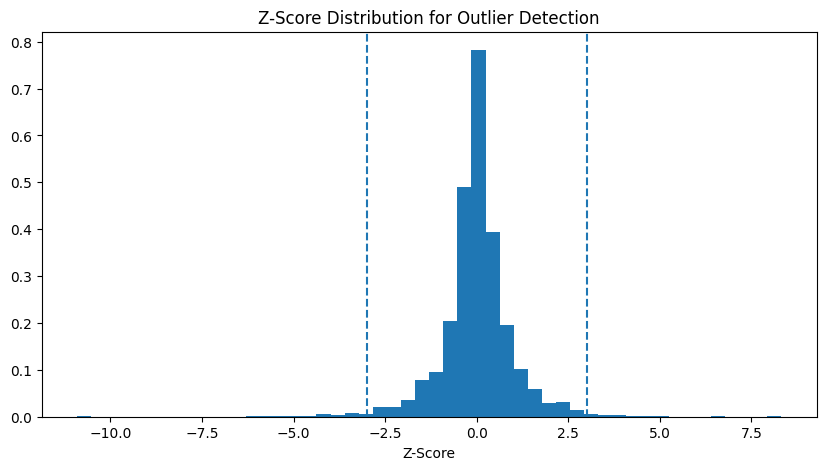

In [48]:
plt.figure(figsize=(10,5))
plt.hist(df1['z_score'], bins=50, density=True)
plt.axvline(3, linestyle='--')
plt.axvline(-3, linestyle='--')
plt.title("Z-Score Distribution for Outlier Detection")
plt.xlabel("Z-Score")
plt.show()


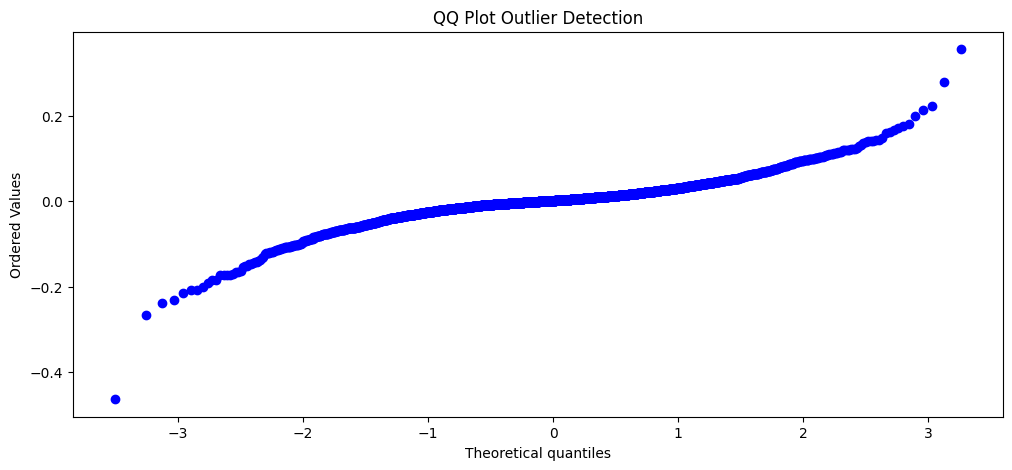

In [49]:
import scipy.stats as stats

plt.figure(figsize=(12,5))
stats.probplot(df['log_return'], dist="norm", plot=plt)
plt.title("QQ Plot Outlier Detection")
plt.show()


In [50]:
df1['log_return_capped'] = df1['log_return'].clip(lower_bound, upper_bound)
df1[['log_return','log_return_capped']]


,log_return,log_return_capped
0,0.001829,0.001829
1,-0.039082,-0.039082
2,-0.172385,-0.060476
3,-0.106130,-0.060476
4,-0.073545,-0.060476
...,...,...
2986,0.009632,0.009632
2987,0.022505,0.022505
2988,0.017704,0.017704
2989,-0.044675,-0.044675


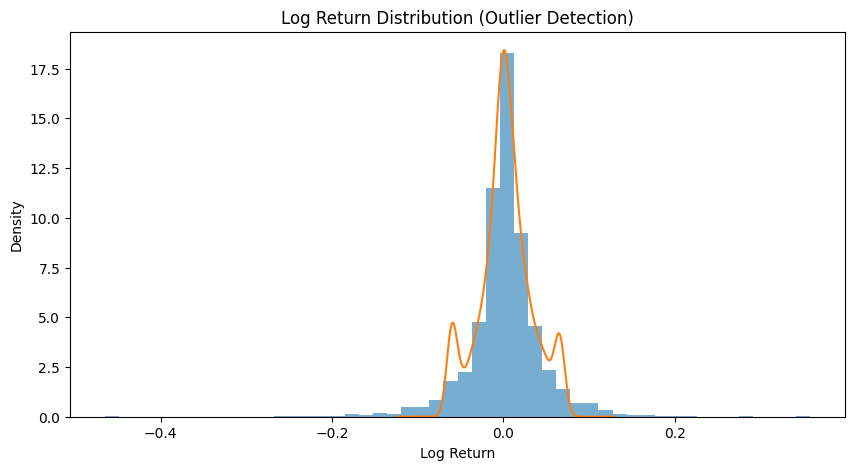

In [51]:
plt.figure(figsize=(10,5))
plt.hist(df1['log_return'], bins=50, density=True, alpha=0.6)
df1['log_return_capped'].dropna().plot(kind='kde')
plt.title("Log Return Distribution (Outlier Detection)")
plt.xlabel("Log Return")
plt.show()


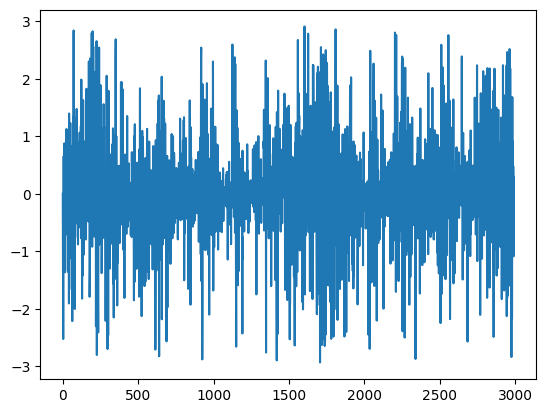

In [52]:
plt.plot(df1[np.abs(df1['z_score']) <= 3].z_score)


B. Visualizing Outliers

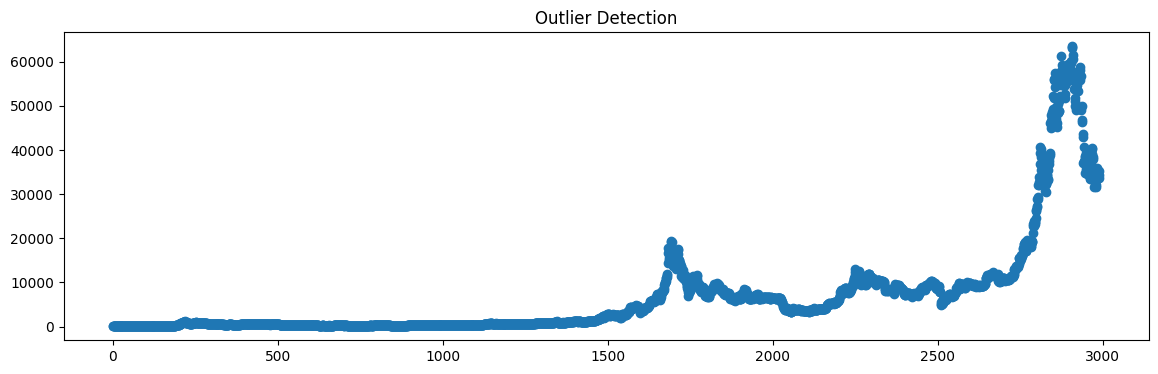

In [53]:
plt.figure(figsize=(14,4))
plt.scatter(df1.index, df1['Close'])
plt.title("Outlier Detection")
plt.show()


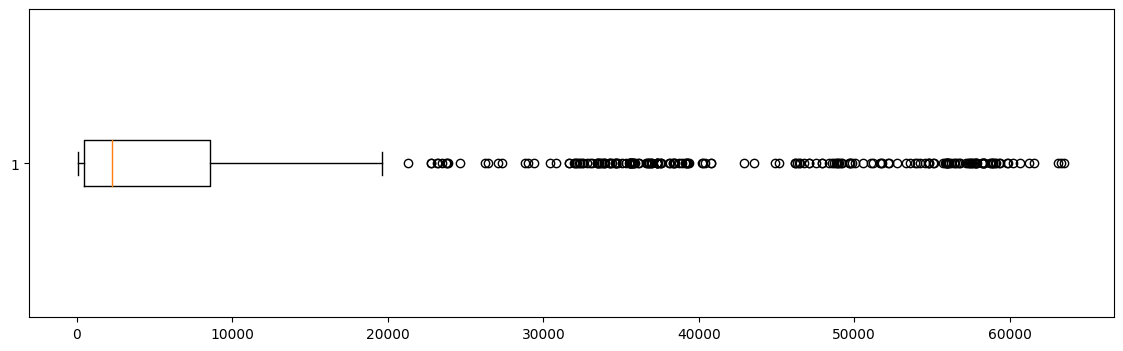

In [54]:
plt.figure(figsize=(14,4))
plt.boxplot(df['Close'], vert=False)
plt.show()      


In [55]:
df1.head(40)


,SNo,Name,Symbol,Date,High,Low,Open,Close,Volume,Marketcap,...,Trend,Seasonal,Residual,log_return,volatility_7,volatility_15,volatility_30,volatility_regime_30,z_score,log_return_capped
0,1,Bitcoin,BTC,2013-04-29 23:59:59,147.488007,134.000000,134.444000,144.539993,0.0,1.603769e+09,...,124.513648,13.510565,6.515781,0.001829,0.034614,0.036281,0.037536,Low Volatility,5.073006e-18,0.001829
1,2,Bitcoin,BTC,2013-04-30 23:59:59,146.929993,134.050003,144.000000,139.000000,0.0,1.542813e+09,...,122.352521,9.877990,6.769489,-0.039082,0.034614,0.036281,0.037536,Low Volatility,-9.571148e-01,-0.039082
2,3,Bitcoin,BTC,2013-05-01 23:59:59,139.889999,107.720001,139.000000,116.989998,0.0,1.298955e+09,...,120.357377,-2.213524,-1.153856,-0.172385,0.034614,0.036281,0.037536,Low Volatility,-4.075758e+00,-0.060476
3,4,Bitcoin,BTC,2013-05-02 23:59:59,125.599998,92.281898,116.379997,105.209999,0.0,1.168517e+09,...,118.507575,-8.172636,-5.124941,-0.106130,0.034614,0.036281,0.037536,Low Volatility,-2.525705e+00,-0.060476
4,5,Bitcoin,BTC,2013-05-03 23:59:59,108.127998,79.099998,106.250000,97.750000,0.0,1.085995e+09,...,116.770600,-9.894992,-9.125608,-0.073545,0.034614,0.036281,0.037536,Low Volatility,-1.763377e+00,-0.060476
5,6,Bitcoin,BTC,2013-05-04 23:59:59,115.000000,92.500000,98.099998,112.500000,0.0,1.250317e+09,...,115.115049,-0.856087,-1.758962,0.140540,0.034614,0.036281,0.037536,Low Volatility,3.245170e+00,0.065881
6,7,Bitcoin,BTC,2013-05-05 23:59:59,118.800003,107.142998,112.900002,115.910004,0.0,1.288693e+09,...,113.531855,2.108437,0.269712,0.029861,0.034614,0.036281,0.037536,Low Volatility,6.558178e-01,0.029861
7,8,Bitcoin,BTC,2013-05-06 23:59:59,124.663002,106.639999,115.980003,112.300003,0.0,1.249023e+09,...,112.364400,8.478740,-8.543137,-0.031640,0.100384,0.036281,0.037536,Low Volatility,-7.830052e-01,-0.031640
8,9,Bitcoin,BTC,2013-05-07 23:59:59,113.444000,97.699997,112.250000,111.500000,0.0,1.240594e+09,...,112.709401,5.277202,-6.486603,-0.007149,0.100947,0.036281,0.037536,Low Volatility,-2.100385e-01,-0.007149
9,10,Bitcoin,BTC,2013-05-08 23:59:59,115.779999,109.599998,109.599998,113.566002,0.0,1.264049e+09,...,113.194003,-1.662594,2.034593,0.018360,0.080186,0.036281,0.037536,Low Volatility,3.867449e-01,0.018360


## Data Preprocessing

In [160]:
data = df1.sort_values('Date')
data.set_index('Date', inplace=True)


In [161]:
data


,SNo,Name,Symbol,High,Low,Open,Close,Volume,Marketcap,MA_7,...,Trend,Seasonal,Residual,log_return,volatility_7,volatility_15,volatility_30,volatility_regime_30,z_score,log_return_capped
Date,,,,,,,,,,,,,,,,,,,,,
2013-04-29 23:59:59,1,Bitcoin,BTC,147.488007,134.000000,134.444000,144.539993,0.000000e+00,1.603769e+09,6690.163677,...,124.513648,13.510565,6.515781,0.001829,0.034614,0.036281,0.037536,Low Volatility,5.073006e-18,0.001829
2013-04-30 23:59:59,2,Bitcoin,BTC,146.929993,134.050003,144.000000,139.000000,0.000000e+00,1.542813e+09,6690.163677,...,122.352521,9.877990,6.769489,-0.039082,0.034614,0.036281,0.037536,Low Volatility,-9.571148e-01,-0.039082
2013-05-01 23:59:59,3,Bitcoin,BTC,139.889999,107.720001,139.000000,116.989998,0.000000e+00,1.298955e+09,6690.163677,...,120.357377,-2.213524,-1.153856,-0.172385,0.034614,0.036281,0.037536,Low Volatility,-4.075758e+00,-0.060476
2013-05-02 23:59:59,4,Bitcoin,BTC,125.599998,92.281898,116.379997,105.209999,0.000000e+00,1.168517e+09,6690.163677,...,118.507575,-8.172636,-5.124941,-0.106130,0.034614,0.036281,0.037536,Low Volatility,-2.525705e+00,-0.060476
2013-05-03 23:59:59,5,Bitcoin,BTC,108.127998,79.099998,106.250000,97.750000,0.000000e+00,1.085995e+09,6690.163677,...,116.770600,-9.894992,-9.125608,-0.073545,0.034614,0.036281,0.037536,Low Volatility,-1.763377e+00,-0.060476
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-07-02 23:59:59,2987,Bitcoin,BTC,33939.588699,32770.680780,33549.600177,33897.048590,3.872897e+10,6.354508e+11,34235.434114,...,34332.563133,-1095.522467,660.007923,0.009632,0.039215,0.052242,0.051774,High Volatility,1.825632e-01,0.009632
2021-07-03 23:59:59,2988,Bitcoin,BTC,34909.259899,33402.696536,33854.421362,34668.548402,2.438396e+10,6.499397e+11,34590.044219,...,34335.445545,-130.190373,463.293229,0.022505,0.039432,0.050547,0.051287,High Volatility,4.837258e-01,0.022505
2021-07-04 23:59:59,2989,Bitcoin,BTC,35937.567147,34396.477458,34665.564866,35287.779766,2.492431e+10,6.615748e+11,34681.206387,...,34327.893632,1070.089444,-110.203309,0.017704,0.028708,0.050795,0.050286,High Volatility,3.714033e-01,0.017704


In [162]:
# Ensure datetime index
data.index = pd.to_datetime(data.index)
data.head()


,SNo,Name,Symbol,High,Low,Open,Close,Volume,Marketcap,MA_7,...,Trend,Seasonal,Residual,log_return,volatility_7,volatility_15,volatility_30,volatility_regime_30,z_score,log_return_capped
Date,,,,,,,,,,,,,,,,,,,,,
2013-04-29 23:59:59,1,Bitcoin,BTC,147.488007,134.000000,134.444000,144.539993,0.0,1.603769e+09,6690.163677,...,124.513648,13.510565,6.515781,0.001829,0.034614,0.036281,0.037536,Low Volatility,5.073006e-18,0.001829
2013-04-30 23:59:59,2,Bitcoin,BTC,146.929993,134.050003,144.000000,139.000000,0.0,1.542813e+09,6690.163677,...,122.352521,9.877990,6.769489,-0.039082,0.034614,0.036281,0.037536,Low Volatility,-9.571148e-01,-0.039082
2013-05-01 23:59:59,3,Bitcoin,BTC,139.889999,107.720001,139.000000,116.989998,0.0,1.298955e+09,6690.163677,...,120.357377,-2.213524,-1.153856,-0.172385,0.034614,0.036281,0.037536,Low Volatility,-4.075758e+00,-0.060476
2013-05-02 23:59:59,4,Bitcoin,BTC,125.599998,92.281898,116.379997,105.209999,0.0,1.168517e+09,6690.163677,...,118.507575,-8.172636,-5.124941,-0.106130,0.034614,0.036281,0.037536,Low Volatility,-2.525705e+00,-0.060476
2013-05-03 23:59:59,5,Bitcoin,BTC,108.127998,79.099998,106.250000,97.750000,0.0,1.085995e+09,6690.163677,...,116.770600,-9.894992,-9.125608,-0.073545,0.034614,0.036281,0.037536,Low Volatility,-1.763377e+00,-0.060476


In [163]:
# Check missing dates
missing_dates = pd.date_range(start=data.index.min(), end=data.index.max(), freq='D').difference(data.index)
print(f"Missing timestamps: {len(missing_dates)}")


Missing timestamps: 0


In [164]:
data.columns


Index(['SNo', 'Name', 'Symbol', 'High', 'Low', 'Open', 'Close', 'Volume',
       'Marketcap', 'MA_7', 'MA_15', 'MA_30', 'Trend', 'Seasonal', 'Residual',
       'log_return', 'volatility_7', 'volatility_15', 'volatility_30',
       'volatility_regime_30', 'z_score', 'log_return_capped'],
      dtype='object')

#### Outlier Handling Strategy

In [165]:
data['log_return_capped'] = data['log_return'].clip(lower_bound, upper_bound)
data[['log_return','log_return_capped']].head(10)


,log_return,log_return_capped
Date,,
2013-04-29 23:59:59,0.001829,0.001829
2013-04-30 23:59:59,-0.039082,-0.039082
2013-05-01 23:59:59,-0.172385,-0.060476
2013-05-02 23:59:59,-0.106130,-0.060476
2013-05-03 23:59:59,-0.073545,-0.060476
2013-05-04 23:59:59,0.140540,0.065881
2013-05-05 23:59:59,0.029861,0.029861
2013-05-06 23:59:59,-0.031640,-0.031640
2013-05-07 23:59:59,-0.007149,-0.007149


#### Scale data using training-only fit (no leakage)
##### Chronological Split (Used Before Scaling)

In [166]:
def create_lag_features(data: pd.DataFrame, target_col: str, max_lag: int = 30) -> pd.DataFrame:
    """
    Create lag features for a time-series target column.
    Parameters:
     data : pd.DataFrame
        Time-indexed dataframe
     target_col : str
        Target column name (e.g., 'Close')
     max_lag : int
        Number of lag features to create
    Returns:
    pd.DataFrame
        DataFrame with lag features
    """
    df_lag = data.copy()
    for lag in range(1, max_lag + 1):
        df_lag[f'{target_col}_lag_{lag}'] = df_lag[target_col].shift(lag)
    df_lag.dropna(inplace=True)
    return df_lag


In [167]:
final_data = data.copy()


In [168]:
final_data[['High', 'Low', 'Open', 'Close', 'Volume', 'Marketcap', 'MA_7', 'MA_15', 'MA_30', 'log_return', 'volatility_7', 'volatility_15', 'volatility_30', 'volatility_regime_30', 'z_score', 'log_return_capped']]


,High,Low,Open,Close,Volume,Marketcap,MA_7,MA_15,MA_30,log_return,volatility_7,volatility_15,volatility_30,volatility_regime_30,z_score,log_return_capped
Date,,,,,,,,,,,,,,,,
2013-04-29 23:59:59,147.488007,134.000000,134.444000,144.539993,0.000000e+00,1.603769e+09,6690.163677,6661.912140,6606.573392,0.001829,0.034614,0.036281,0.037536,Low Volatility,5.073006e-18,0.001829
2013-04-30 23:59:59,146.929993,134.050003,144.000000,139.000000,0.000000e+00,1.542813e+09,6690.163677,6661.912140,6606.573392,-0.039082,0.034614,0.036281,0.037536,Low Volatility,-9.571148e-01,-0.039082
2013-05-01 23:59:59,139.889999,107.720001,139.000000,116.989998,0.000000e+00,1.298955e+09,6690.163677,6661.912140,6606.573392,-0.172385,0.034614,0.036281,0.037536,Low Volatility,-4.075758e+00,-0.060476
2013-05-02 23:59:59,125.599998,92.281898,116.379997,105.209999,0.000000e+00,1.168517e+09,6690.163677,6661.912140,6606.573392,-0.106130,0.034614,0.036281,0.037536,Low Volatility,-2.525705e+00,-0.060476
2013-05-03 23:59:59,108.127998,79.099998,106.250000,97.750000,0.000000e+00,1.085995e+09,6690.163677,6661.912140,6606.573392,-0.073545,0.034614,0.036281,0.037536,Low Volatility,-1.763377e+00,-0.060476
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-07-02 23:59:59,33939.588699,32770.680780,33549.600177,33897.048590,3.872897e+10,6.354508e+11,34235.434114,34063.669852,35618.790261,0.009632,0.039215,0.052242,0.051774,High Volatility,1.825632e-01,0.009632
2021-07-03 23:59:59,34909.259899,33402.696536,33854.421362,34668.548402,2.438396e+10,6.499397e+11,34590.044219,33989.090093,35467.449674,0.022505,0.039432,0.050547,0.051287,High Volatility,4.837258e-01,0.022505
2021-07-04 23:59:59,35937.567147,34396.477458,34665.564866,35287.779766,2.492431e+10,6.615748e+11,34681.206387,33967.217460,35413.895489,0.017704,0.028708,0.050795,0.050286,High Volatility,3.714033e-01,0.017704


In [169]:
encoded_data = final_data.copy()


In [170]:
encode = {"Low Volatility":0, "High Volatility":1}
encoded_data["volatility_regime_30"] = encoded_data.volatility_regime_30.map(encode)
encoded_data


,SNo,Name,Symbol,High,Low,Open,Close,Volume,Marketcap,MA_7,...,Trend,Seasonal,Residual,log_return,volatility_7,volatility_15,volatility_30,volatility_regime_30,z_score,log_return_capped
Date,,,,,,,,,,,,,,,,,,,,,
2013-04-29 23:59:59,1,Bitcoin,BTC,147.488007,134.000000,134.444000,144.539993,0.000000e+00,1.603769e+09,6690.163677,...,124.513648,13.510565,6.515781,0.001829,0.034614,0.036281,0.037536,0,5.073006e-18,0.001829
2013-04-30 23:59:59,2,Bitcoin,BTC,146.929993,134.050003,144.000000,139.000000,0.000000e+00,1.542813e+09,6690.163677,...,122.352521,9.877990,6.769489,-0.039082,0.034614,0.036281,0.037536,0,-9.571148e-01,-0.039082
2013-05-01 23:59:59,3,Bitcoin,BTC,139.889999,107.720001,139.000000,116.989998,0.000000e+00,1.298955e+09,6690.163677,...,120.357377,-2.213524,-1.153856,-0.172385,0.034614,0.036281,0.037536,0,-4.075758e+00,-0.060476
2013-05-02 23:59:59,4,Bitcoin,BTC,125.599998,92.281898,116.379997,105.209999,0.000000e+00,1.168517e+09,6690.163677,...,118.507575,-8.172636,-5.124941,-0.106130,0.034614,0.036281,0.037536,0,-2.525705e+00,-0.060476
2013-05-03 23:59:59,5,Bitcoin,BTC,108.127998,79.099998,106.250000,97.750000,0.000000e+00,1.085995e+09,6690.163677,...,116.770600,-9.894992,-9.125608,-0.073545,0.034614,0.036281,0.037536,0,-1.763377e+00,-0.060476
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-07-02 23:59:59,2987,Bitcoin,BTC,33939.588699,32770.680780,33549.600177,33897.048590,3.872897e+10,6.354508e+11,34235.434114,...,34332.563133,-1095.522467,660.007923,0.009632,0.039215,0.052242,0.051774,1,1.825632e-01,0.009632
2021-07-03 23:59:59,2988,Bitcoin,BTC,34909.259899,33402.696536,33854.421362,34668.548402,2.438396e+10,6.499397e+11,34590.044219,...,34335.445545,-130.190373,463.293229,0.022505,0.039432,0.050547,0.051287,1,4.837258e-01,0.022505
2021-07-04 23:59:59,2989,Bitcoin,BTC,35937.567147,34396.477458,34665.564866,35287.779766,2.492431e+10,6.615748e+11,34681.206387,...,34327.893632,1070.089444,-110.203309,0.017704,0.028708,0.050795,0.050286,1,3.714033e-01,0.017704


In [171]:
added_lag_features_df = create_lag_features(encoded_data, target_col='Close', max_lag=30)
added_lag_features_df.columns


Index(['SNo', 'Name', 'Symbol', 'High', 'Low', 'Open', 'Close', 'Volume',
       'Marketcap', 'MA_7', 'MA_15', 'MA_30', 'Trend', 'Seasonal', 'Residual',
       'log_return', 'volatility_7', 'volatility_15', 'volatility_30',
       'volatility_regime_30', 'z_score', 'log_return_capped', 'Close_lag_1',
       'Close_lag_2', 'Close_lag_3', 'Close_lag_4', 'Close_lag_5',
       'Close_lag_6', 'Close_lag_7', 'Close_lag_8', 'Close_lag_9',
       'Close_lag_10', 'Close_lag_11', 'Close_lag_12', 'Close_lag_13',
       'Close_lag_14', 'Close_lag_15', 'Close_lag_16', 'Close_lag_17',
       'Close_lag_18', 'Close_lag_19', 'Close_lag_20', 'Close_lag_21',
       'Close_lag_22', 'Close_lag_23', 'Close_lag_24', 'Close_lag_25',
       'Close_lag_26', 'Close_lag_27', 'Close_lag_28', 'Close_lag_29',
       'Close_lag_30'],
      dtype='object')

In [172]:
added_lag_features_df['target'] = added_lag_features_df['log_return'].shift(-1)
added_lag_features_df.head()


,SNo,Name,Symbol,High,Low,Open,Close,Volume,Marketcap,MA_7,...,Close_lag_22,Close_lag_23,Close_lag_24,Close_lag_25,Close_lag_26,Close_lag_27,Close_lag_28,Close_lag_29,Close_lag_30,target
Date,,,,,,,,,,,,,,,,,,,,,
2013-05-29 23:59:59,31,Bitcoin,BTC,132.589996,127.662003,129.000000,132.300003,0.0,1.483735e+09,130.914998,...,111.500000,112.300003,115.910004,112.500000,97.750000,105.209999,116.989998,139.000000,144.539993,-0.026819
2013-05-30 23:59:59,32,Bitcoin,BTC,132.250000,127.000000,132.250000,128.798996,0.0,1.445054e+09,131.214855,...,113.566002,111.500000,112.300003,115.910004,112.500000,97.750000,105.209999,116.989998,139.000000,0.001559
2013-05-31 23:59:59,33,Bitcoin,BTC,129.899994,126.400002,128.798996,129.000000,0.0,1.447870e+09,130.614855,...,112.669998,113.566002,111.500000,112.300003,115.910004,112.500000,97.750000,105.209999,116.989998,0.002323
2013-06-01 23:59:59,34,Bitcoin,BTC,129.779999,127.198997,128.815002,129.300003,0.0,1.451916e+09,130.231999,...,117.199997,112.669998,113.566002,111.500000,112.300003,115.910004,112.500000,97.750000,105.209999,-0.055724
2013-06-02 23:59:59,35,Bitcoin,BTC,129.399994,115.050003,129.300003,122.292000,0.0,1.373837e+09,128.633714,...,115.242996,117.199997,112.669998,113.566002,111.500000,112.300003,115.910004,112.500000,97.750000,-0.000573


In [173]:
INPUT_FEATURES = [
    # Market information
    'Volume', 'Marketcap',
    # Trend indicators
    'MA_7', 'MA_15', 'MA_30',
    # Volatility indicators (CRITICAL for crypto)
    'volatility_7', 'volatility_15', 'volatility_30',
    # Regime & distribution info
    'volatility_regime_30',
    # Price structure (lagged)
    'Close_lag_1', 'Close_lag_2', 'Close_lag_3', 'Close_lag_4', 'Close_lag_5', 'Close_lag_6', 'Close_lag_7', 'Close_lag_8', 'Close_lag_9', 'Close_lag_10',
    'Close_lag_11', 'Close_lag_12', 'Close_lag_13', 'Close_lag_14', 'Close_lag_15', 'Close_lag_16', 'Close_lag_17', 'Close_lag_18', 'Close_lag_19', 'Close_lag_20',
    'Close_lag_21', 'Close_lag_22', 'Close_lag_23', 'Close_lag_24', 'Close_lag_25', 'Close_lag_26', 'Close_lag_27', 'Close_lag_28', 'Close_lag_29', 'Close_lag_30']

TARGET = 'target'


In [174]:


model_df = added_lag_features_df[INPUT_FEATURES + ['target']].dropna()


# model_df = added_lag_features_df[INPUT_FEATURES + ['log_return']].dropna()
model_df


,Volume,Marketcap,MA_7,MA_15,MA_30,volatility_7,volatility_15,volatility_30,volatility_regime_30,Close_lag_1,...,Close_lag_22,Close_lag_23,Close_lag_24,Close_lag_25,Close_lag_26,Close_lag_27,Close_lag_28,Close_lag_29,Close_lag_30,target
Date,,,,,,,,,,,,,,,,,,,,,
2013-05-29 23:59:59,0.000000e+00,1.483735e+09,130.914998,125.777132,120.032533,0.026074,0.021329,0.053742,1,129.000000,...,111.500000,112.300003,115.910004,112.500000,97.750000,105.209999,116.989998,139.000000,144.539993,-0.026819
2013-05-30 23:59:59,0.000000e+00,1.445054e+09,131.214855,126.749065,119.692499,0.028498,0.023139,0.053504,1,132.300003,...,113.566002,111.500000,112.300003,115.910004,112.500000,97.750000,105.209999,116.989998,139.000000,0.001559
2013-05-31 23:59:59,0.000000e+00,1.447870e+09,130.614855,127.431732,120.092833,0.019426,0.021523,0.042822,0,128.798996,...,112.669998,113.566002,111.500000,112.300003,115.910004,112.500000,97.750000,105.209999,116.989998,0.002323
2013-06-01 23:59:59,0.000000e+00,1.451916e+09,130.231999,127.850732,120.895833,0.019457,0.019896,0.037518,0,129.000000,...,117.199997,112.669998,113.566002,111.500000,112.300003,115.910004,112.500000,97.750000,105.209999,-0.055724
2013-06-02 23:59:59,0.000000e+00,1.373837e+09,128.633714,127.770332,121.713899,0.026502,0.025058,0.036323,0,129.300003,...,115.242996,117.199997,112.669998,113.566002,111.500000,112.300003,115.910004,112.500000,97.750000,-0.000573
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-07-01 23:59:59,3.783896e+10,6.293393e+11,33912.681466,34340.766891,35741.394627,0.054779,0.052022,0.051965,1,35040.837249,...,37345.121486,33472.631748,33560.707838,35862.377727,35551.958726,36894.405330,39208.765995,37575.179576,36684.924517,0.009632
2021-07-02 23:59:59,3.872897e+10,6.354508e+11,34235.434114,34063.669852,35618.790261,0.039215,0.052242,0.051774,1,33572.117653,...,36702.599375,37345.121486,33472.631748,33560.707838,35862.377727,35551.958726,36894.405330,39208.765995,37575.179576,0.022505
2021-07-03 23:59:59,2.438396e+10,6.499397e+11,34590.044219,33989.090093,35467.449674,0.039432,0.050547,0.051287,1,33897.048590,...,37334.399526,36702.599375,37345.121486,33472.631748,33560.707838,35862.377727,35551.958726,36894.405330,39208.765995,0.017704


In [175]:
n = len(model_df)
train_end = int(0.70 * n)
val_end   = int(0.85 * n)


In [176]:
X_train = model_df[INPUT_FEATURES].iloc[:train_end]
y_train = model_df[TARGET].iloc[:train_end]
X_val = model_df[INPUT_FEATURES].iloc[train_end:val_end]
y_val = model_df[TARGET].iloc[train_end:val_end]
X_test = model_df[INPUT_FEATURES].iloc[val_end:]
y_test = model_df[TARGET].iloc[val_end:]
print(X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape)


(2072, 39) (2072,) (444, 39) (444,) (444, 39) (444,)


##### Scalling

In [177]:
X_scaler = MinMaxScaler()
# FIT only on training data
X_scaler.fit(X_train)


MinMaxScaler()

In [178]:
# TRANSFORM all splits
X_train_scaled = X_scaler.transform(X_train)
X_val_scaled   = X_scaler.transform(X_val)
X_test_scaled  = X_scaler.transform(X_test)


In [179]:
y_scaler = MinMaxScaler()

# reshape because scaler expects 2D
y_train_scaled = y_scaler.fit_transform(y_train.values.reshape(-1, 1))
y_val_scaled   = y_scaler.transform(y_val.values.reshape(-1, 1))
y_test_scaled  = y_scaler.transform(y_test.values.reshape(-1, 1))


In [180]:
print(X_train_scaled.min(), X_train_scaled.max())  # should be ~0 to 1
print(X_test_scaled.min(), X_test_scaled.max())    # may exceed [0,1] → OK


0.0 1.0000000000000002
0.0 14.721254446786158


### Baseline model

Evaluation Method

In [181]:
def evaluate_model(y_true, y_pred):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    direction_accuracy = np.mean(np.sign(y_true.diff().dropna().values) == np.sign(np.diff(y_pred)))
    return rmse, mae, mape, direction_accuracy


#### Model_1 == ARIMA

In [182]:
# Fit ARIMA on training close price
arima_model = ARIMA(y_train, order=(1,0,1))
arima_fit = arima_model.fit()


In [183]:
arima_preds = arima_fit.forecast(steps=len(y_test))


In [184]:
arima_rmse, arima_mae, arima_mape, arima_dir = evaluate_model(y_test.reset_index(drop=True),pd.Series(arima_preds))
arima_rmse, arima_mae, arima_mape, arima_dir


(0.03840062658342789, 0.026685380159074693, nan, 0.04966139954853273)

#### Model_2 == Linear Regression with Lag Features

In [185]:
lr = LinearRegression()


In [186]:
lr.fit(X_train_scaled, y_train_scaled.ravel())


LinearRegression()

In [187]:
lr_preds_scaled = lr.predict(X_test_scaled)
lr_preds = y_scaler.inverse_transform(lr_preds_scaled.reshape(-1,1)).flatten()


In [188]:
lr_rmse, lr_mae, lr_mape, lr_dir = evaluate_model(y_test.reset_index(drop=True), lr_preds)
lr_rmse, lr_mae, lr_mape, lr_dir


(0.05921982768941276,
 0.04266558958595093,
 1545.5903394475963,
 0.4717832957110609)

#### Model_3 == RandomForest Regressor

In [85]:
rf = RandomForestRegressor(n_estimators=300, max_depth=10, min_samples_leaf=10, random_state=42, n_jobs=-1)
rf.fit(X_train_scaled, y_train_scaled.ravel())
rf_preds_scaled = rf.predict(X_test_scaled)
rf_preds = y_scaler.inverse_transform(rf_preds_scaled.reshape(-1,1)).flatten()


In [86]:
rf_rmse, rf_mae, rf_mape, rf_dir = evaluate_model(y_test.reset_index(drop=True), rf_preds)
rf_rmse, rf_mae, rf_mape, rf_dir


(0.050877372744325924,
 0.0375211600441252,
 900.4722849641878,
 0.40857787810383744)

#### XGBoost

In [87]:
xgb_model = XGBRegressor(n_estimators=500, max_depth=5, learning_rate=0.05, subsample=0.8, colsample_bytree=0.8,
                         objective='reg:squarederror', random_state=42, n_jobs=-1)


In [88]:
xgb_model.fit(X_train_scaled, y_train, eval_set=[(X_val_scaled, y_val)], verbose=False)


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.05, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=5,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=500,
             n_jobs=-1, num_parallel_tree=None, ...)

In [89]:
xgb_preds = xgb_model.predict(X_test_scaled)


In [90]:
xgb_rmse, xgb_mae, xgb_mape, xgb_dir = evaluate_model(y_test.reset_index(drop=True), xgb_preds)
xgb_rmse, xgb_mae, xgb_mape, xgb_dir



(0.0687463786909878,
 0.05385943268018933,
 1748.8913896662496,
 0.5304740406320542)

In [91]:
xgb_importance = pd.Series(xgb_model.feature_importances_, index=INPUT_FEATURES).sort_values(ascending=False)
xgb_importance.head(10)


Close_lag_6      0.037446
Close_lag_28     0.037444
Close_lag_26     0.035900
Close_lag_30     0.034218
Close_lag_25     0.032623
Close_lag_1      0.032333
Close_lag_3      0.031214
Close_lag_29     0.030422
Close_lag_13     0.028237
volatility_30    0.028123
dtype: float32

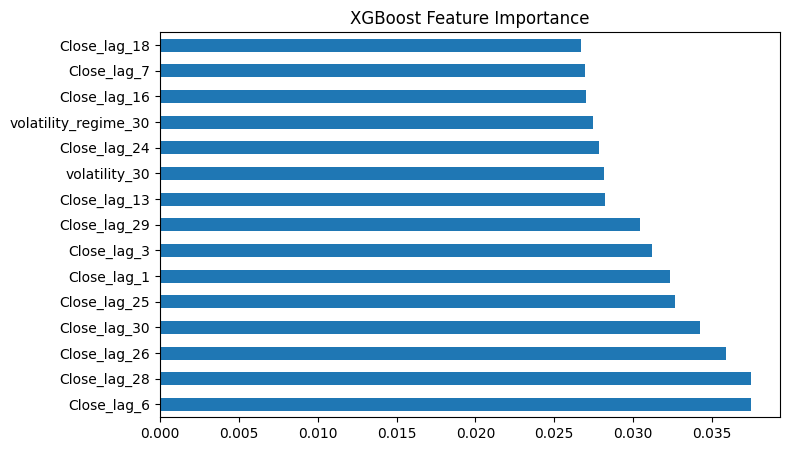

In [92]:
xgb_importance.head(15).plot(kind='barh', figsize=(8,5))
plt.title("XGBoost Feature Importance")
plt.show()


#### Model Comparision Table

In [93]:
results = pd.DataFrame({'Model': ['ARIMA', 'Linear Regression', 'Random Forest', 'XGBoost'],
                        'RMSE': [arima_rmse, lr_rmse, rf_rmse, xgb_rmse],
                        'MAE': [arima_mae, lr_mae, rf_mae, xgb_mae],
                        'MAPE (%)': [arima_mape, lr_mape, rf_mape, xgb_mape],
                        'Directional Accuracy': [arima_dir, lr_dir, rf_dir, xgb_dir]})
results


,Model,RMSE,MAE,MAPE (%),Directional Accuracy
0,ARIMA,0.038401,0.026685,NaN,0.049661
1,Linear Regression,0.059220,0.042666,1545.590339,0.471783
2,Random Forest,0.050877,0.037521,900.472285,0.408578
3,XGBoost,0.068746,0.053859,1748.891390,0.530474


### Deep learning Models
#### LSTM
##### Sequence Window Creation

In [94]:
lstm_data = encoded_data[['Close', 'Volume', 'Marketcap', 'MA_7', 'MA_15', 'MA_30', 'volatility_7', 'volatility_15', 'volatility_30', 'volatility_regime_30']]
lstm_data['target_price'] = lstm_data['Close'].shift(-1)
lstm_data.head(3)


,Close,Volume,Marketcap,MA_7,MA_15,MA_30,volatility_7,volatility_15,volatility_30,volatility_regime_30,target_price
Date,,,,,,,,,,,
2013-04-29 23:59:59,144.539993,0.0,1.603769e+09,6690.163677,6661.91214,6606.573392,0.034614,0.036281,0.037536,0,139.000000
2013-04-30 23:59:59,139.000000,0.0,1.542813e+09,6690.163677,6661.91214,6606.573392,0.034614,0.036281,0.037536,0,116.989998
2013-05-01 23:59:59,116.989998,0.0,1.298955e+09,6690.163677,6661.91214,6606.573392,0.034614,0.036281,0.037536,0,105.209999


In [95]:
LSTM_FEATURES = ['Close', 'Volume', 'Marketcap', 'MA_7', 'MA_15', 'MA_30', 'volatility_7', 'volatility_15', 'volatility_30', 'volatility_regime_30']
LSTM_TARGTE = 'target_price'


In [96]:
n = len(lstm_data)
train_end = int(0.70 * n)
val_end   = int(0.85 * n)


In [97]:
train_df = lstm_data.iloc[:train_end]
val_df   = lstm_data.iloc[train_end:val_end]
test_df  = lstm_data.iloc[val_end:]


In [98]:
X_scaler = MinMaxScaler()
y_scaler = MinMaxScaler()


In [ ]:
X_train = X_scaler.fit_transform(train_df[LSTM_FEATURES])
X_val   = X_scaler.transform(val_df[LSTM_FEATURES])
X_test  = X_scaler.transform(test_df[LSTM_FEATURES])

y_train = y_scaler.fit_transform(train_df[[LSTM_TARGTE]])
y_val   = y_scaler.transform(val_df[[LSTM_TARGTE]])
y_test  = y_scaler.transform(test_df[[LSTM_TARGTE]])


In [100]:
X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape


((2093, 10), (2093, 1), (449, 10), (449, 1), (449, 10), (449, 1))

In [101]:
def create_sequences(X, y, window_size):
    X_seq, y_seq = [], []
    for i in range(window_size, len(X)):
        X_seq.append(X[i-window_size:i])
        y_seq.append(y[i])
    return np.array(X_seq), np.array(y_seq)


In [102]:
WINDOW_30 = 30
WINDOW_60 = 60
WINDOW_90 = 90

X_train_seq, y_train_seq = create_sequences(X_train, y_train, WINDOW_60)
X_val_seq, y_val_seq     = create_sequences(X_val, y_val, WINDOW_60)
X_test_seq, y_test_seq   = create_sequences(X_test, y_test, WINDOW_60)


#### LSTM Architecture

In [103]:
lstm_model = Sequential([LSTM(64, return_sequences=True, input_shape=(WINDOW_60, X_train_seq.shape[2])),
                         Dropout(0.3), LSTM(32),
                         Dropout(0.3),
                         Dense(1)])


In [104]:
lstm_model.compile(optimizer=Adam(learning_rate=0.001), loss="mse")


In [105]:
lstm_model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 60, 64)            19200     
                                                                 
 dropout (Dropout)           (None, 60, 64)            0         
                                                                 
 lstm_1 (LSTM)               (None, 32)                12416     
                                                                 
 dropout_1 (Dropout)         (None, 32)                0         
                                                                 
 dense (Dense)               (None, 1)                 33        
                                                                 
Total params: 31,649
Trainable params: 31,649
Non-trainable params: 0
_________________________________________________________________


#### Training with EarlyStopping

In [106]:
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
early_stop


In [117]:
lstm_model.fit(X_train_seq, y_train_seq, 
               validation_data=(X_val_seq, y_val_seq), 
               epochs=100, 
               batch_size=32, 
               callbacks=[early_stop], 
               verbose=1)



Epoch 1/100
64/64 [==============================] - 3s 51ms/step - loss: 0.0029 - val_loss: 0.0020
Epoch 2/100
64/64 [==============================] - 3s 47ms/step - loss: 0.0024 - val_loss: 0.0037
Epoch 3/100
64/64 [==============================] - 3s 49ms/step - loss: 0.0020 - val_loss: 0.0016
Epoch 4/100
64/64 [==============================] - 3s 47ms/step - loss: 0.0018 - val_loss: 0.0019
Epoch 5/100
64/64 [==============================] - 3s 47ms/step - loss: 0.0017 - val_loss: 0.0033
Epoch 6/100
64/64 [==============================] - 3s 47ms/step - loss: 0.0016 - val_loss: 0.0023
Epoch 7/100
64/64 [==============================] - 3s 49ms/step - loss: 0.0017 - val_loss: 0.0014
Epoch 8/100
64/64 [==============================] - 3s 48ms/step - loss: 0.0015 - val_loss: 0.0024
Epoch 9/100
64/64 [==============================] - 3s 48ms/step - loss: 0.0012 - val_loss: 0.0031
Epoch 10/100
64/64 [==============================] - 3s 48ms/step - loss: 0.0014 - val_loss: 0.0048

#### LSTM Evaluation (Next-Day Prediction)

In [118]:
lstm_preds_scaled = lstm_model.predict(X_test_seq, verbose=0)


In [119]:
lstm_preds = y_scaler.inverse_transform(lstm_preds_scaled).flatten()
y_true = y_scaler.inverse_transform(y_test_seq).flatten()
pd.DataFrame({'LSTM_Pred': lstm_preds, 'lstm_test': y_true})


,LSTM_Pred,lstm_test
0,9316.348633,9386.787892
1,9269.527344,9450.701987
2,9216.468750,9538.024374
3,9235.300781,9480.255366
4,9244.332031,9411.840462
...,...,...
384,25748.339844,34668.548402
385,25770.189453,35287.779766
386,25741.710938,33746.002456
387,25764.005859,34235.193451


In [189]:
lstm_model.save("../models/lstm_model.h5")


#### Multi-Step Forecasting (7 / 15 / 30 Days)

In [120]:
def multi_step_forecast(model, last_sequence, steps):
    preds = []
    seq = last_sequence.copy()
    for _ in range(steps):
        pred = model.predict(seq.reshape(1, *seq.shape), verbose=0)[0,0]
        preds.append(pred)
        seq = np.roll(seq, -1, axis=0)
        seq[-1, 0] = pred   # update Close feature
    return y_scaler.inverse_transform(np.array(preds).reshape(-1,1))


##### Generate Forecasts 

In [136]:
last_seq = X_test_seq[-1]

forecast_7  = multi_step_forecast(lstm_model, last_seq, 7)
forecast_15 = multi_step_forecast(lstm_model, last_seq, 15)
forecast_30 = multi_step_forecast(lstm_model, last_seq, 30)


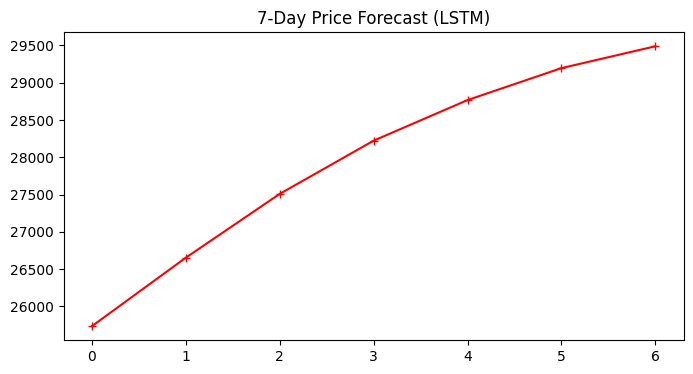

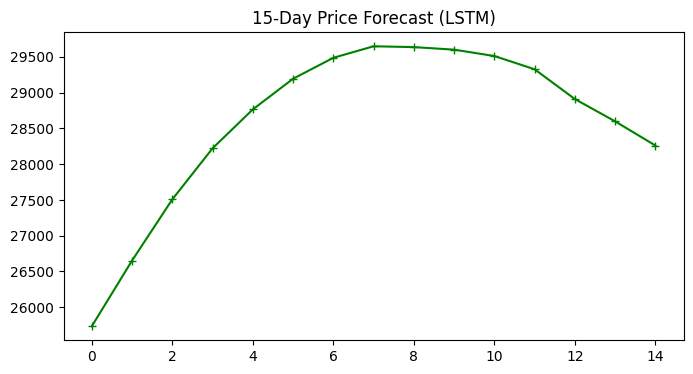

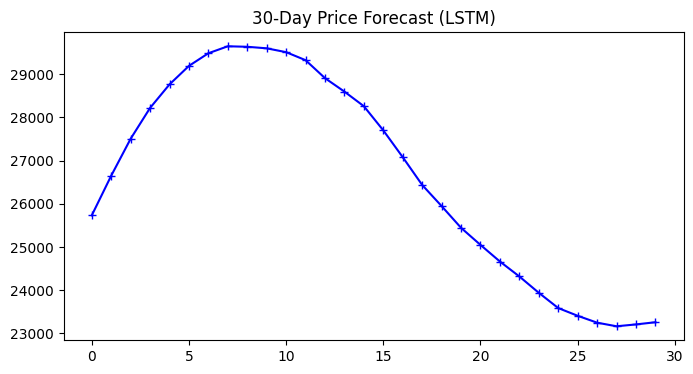

In [137]:
forecast = [forecast_7, forecast_15, forecast_30]
days = [7, 15, 30]
c = ['red','green','blue']
for f, d, color in zip(forecast, days, c):
    plt.figure(figsize=(8,4))
    plt.plot(f, marker='+', color=color)
    plt.title(f"{d}-Day Price Forecast (LSTM)")
    plt.show()


### Build bonus models
like CNN-LSTM

In [138]:
cnn_lstm = Sequential([Conv1D(filters = 64, 
                              kernel_size=3, 
                              activation='relu', 
                              input_shape=(WINDOW_60, X_train_seq.shape[2])),
                       MaxPooling1D(2),
                       LSTM(64),
                       Dropout(0.3),
                       Dense(1)])

# cnn_lstm.compile(optimizer='adam', loss='mse')



In [139]:
cnn_lstm.compile(optimizer=Adam(0.001), loss='mse')


In [140]:
cnn_lstm.summary()  


Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_3 (Conv1D)           (None, 58, 64)            1984      
                                                                 
 max_pooling1d_3 (MaxPooling  (None, 29, 64)           0         
 1D)                                                             
                                                                 
 lstm_5 (LSTM)               (None, 64)                33024     
                                                                 
 dropout_5 (Dropout)         (None, 64)                0         
                                                                 
 dense_4 (Dense)             (None, 1)                 65        
                                                                 
Total params: 35,073
Trainable params: 35,073
Non-trainable params: 0
__________________________________________________

In [141]:
cnn_lstm.fit(X_train_seq, y_train_seq, validation_data=(X_val_seq, y_val_seq), epochs=50, batch_size=32, callbacks=[early_stop], verbose=1)


Epoch 1/50


64/64 [==============================] - 4s 26ms/step - loss: 0.0043 - val_loss: 0.0161
Epoch 2/50
64/64 [==============================] - 1s 21ms/step - loss: 0.0019 - val_loss: 0.0032
Epoch 3/50
64/64 [==============================] - 1s 19ms/step - loss: 0.0015 - val_loss: 0.0024
Epoch 4/50
64/64 [==============================] - 2s 24ms/step - loss: 0.0015 - val_loss: 0.0028
Epoch 5/50
64/64 [==============================] - 1s 21ms/step - loss: 0.0012 - val_loss: 0.0023
Epoch 6/50
64/64 [==============================] - 1s 20ms/step - loss: 0.0015 - val_loss: 0.0027
Epoch 7/50
64/64 [==============================] - 1s 19ms/step - loss: 0.0011 - val_loss: 0.0020
Epoch 8/50
64/64 [==============================] - 1s 20ms/step - loss: 0.0011 - val_loss: 0.0019
Epoch 9/50
64/64 [==============================] - 1s 18ms/step - loss: 9.6051e-04 - val_loss: 0.0019
Epoch 10/50
64/64 [==============================] - 1s 18ms/step - loss: 9.2606e-04 - val_loss: 0.0045
Epoch 11/50


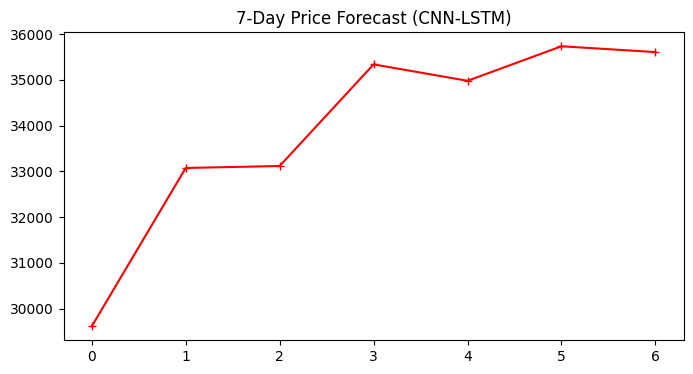

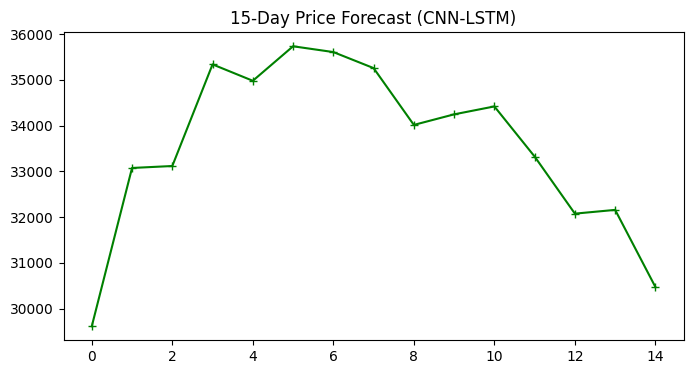

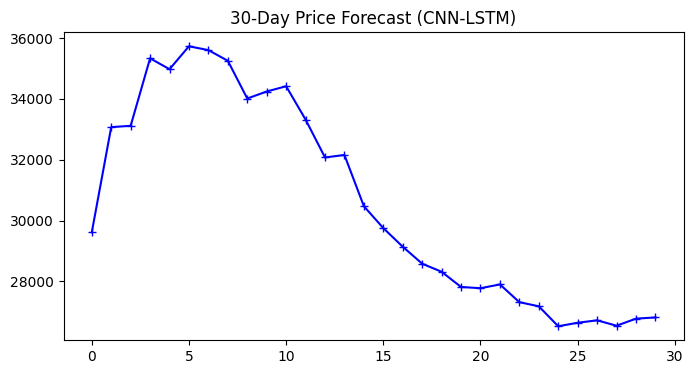

In [157]:
cnn_forecast_7  = multi_step_forecast(cnn_lstm, last_seq, 7)
cnn_forecast_15 = multi_step_forecast(cnn_lstm, last_seq, 15)
cnn_forecast_30 = multi_step_forecast(cnn_lstm, last_seq, 30)
forecast = [cnn_forecast_7, cnn_forecast_15, cnn_forecast_30]
days = [7, 15, 30]
c = ['red','green','blue']
for f, d, color in zip(forecast, days, c):
    plt.figure(figsize=(8,4))
    plt.plot(f, marker='+', color=color)
    plt.title(f"{d}-Day Price Forecast (CNN-LSTM)")
    plt.show()


In [190]:
cnn_lstm.save("../models/cnn_lstm_model.h5")


Attention Based Models
- Simple Attention Mechanism

In [144]:
inputs = Input(shape=(WINDOW_60, X_train_seq.shape[2]))
x = LSTM(64, return_sequences=True)(inputs)
attn = Attention()([x, x])
x = GlobalAveragePooling1D()(attn)
outputs = Dense(1)(x)
attn_model = Model(inputs, outputs)


In [145]:
attn_model.compile(optimizer=Adam(0.001), loss='mse')


In [146]:
attn_model.fit(X_train_seq, y_train_seq, validation_data=(X_val_seq, y_val_seq), epochs=50, batch_size=32, callbacks=[early_stop], verbose=1)


Epoch 1/50
64/64 [==============================] - 5s 45ms/step - loss: 0.0110 - val_loss: 0.0141
Epoch 2/50
64/64 [==============================] - 2s 33ms/step - loss: 0.0045 - val_loss: 0.0175
Epoch 3/50
64/64 [==============================] - 2s 35ms/step - loss: 0.0036 - val_loss: 0.0252
Epoch 4/50
64/64 [==============================] - 2s 34ms/step - loss: 0.0033 - val_loss: 0.0071
Epoch 5/50
64/64 [==============================] - 2s 33ms/step - loss: 0.0021 - val_loss: 0.0159
Epoch 6/50
64/64 [==============================] - 2s 35ms/step - loss: 0.0018 - val_loss: 0.0162
Epoch 7/50
64/64 [==============================] - 2s 36ms/step - loss: 0.0017 - val_loss: 0.0321
Epoch 8/50
64/64 [==============================] - 2s 34ms/step - loss: 0.0012 - val_loss: 0.0394
Epoch 9/50
64/64 [==============================] - 2s 34ms/step - loss: 0.0012 - val_loss: 0.0471


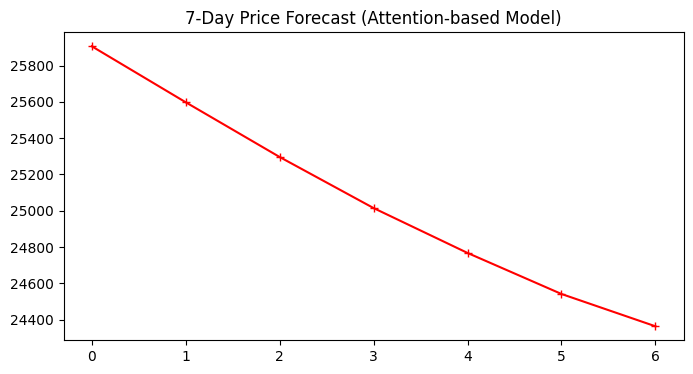

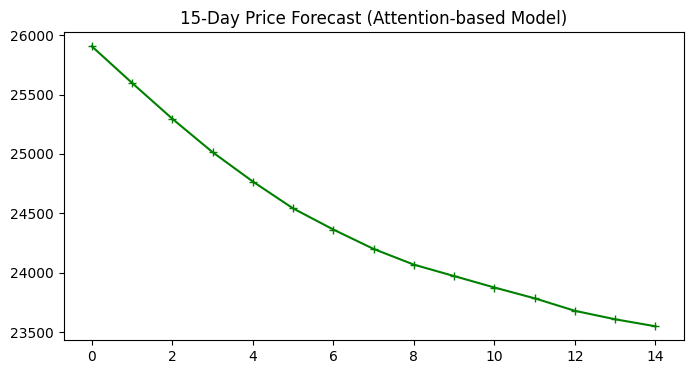

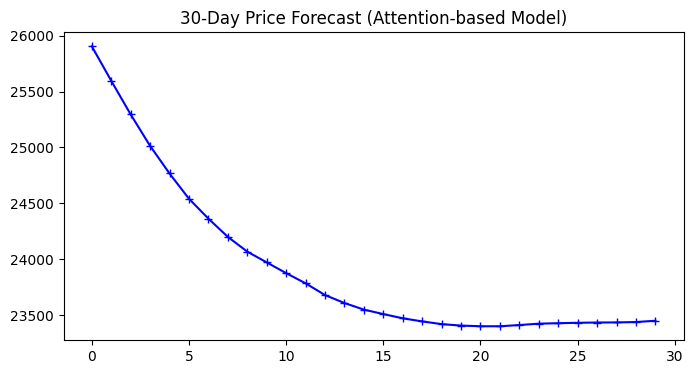

In [158]:
attn_forecast_7  = multi_step_forecast(attn_model, last_seq, 7)
attn_forecast_15 = multi_step_forecast(attn_model, last_seq, 15)
attn_forecast_30 = multi_step_forecast(attn_model, last_seq, 30)
forecast = [attn_forecast_7, attn_forecast_15, attn_forecast_30]
days = [7, 15, 30]
c = ['red','green','blue']
for f, d, color in zip(forecast, days, c):
    plt.figure(figsize=(8,4))
    plt.plot(f, marker='+', color=color)
    plt.title(f"{d}-Day Price Forecast (Attention-based Model)")
    plt.show()


In [191]:
attn_model.save("../models/attention_model.h5")


##### Transformer Time-Series Model

In [149]:
class PositionalEncoding(tf.keras.layers.Layer):
    def __init__(self, seq_len, d_model):
        super().__init__()
        pos = np.arange(seq_len)[:, np.newaxis]
        i = np.arange(d_model)[np.newaxis, :]
        angle_rates = 1 / np.power(10000, (2 * (i // 2)) / np.float32(d_model))
        angle_rads = pos * angle_rates
        angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])
        angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])
        self.pos_encoding = tf.constant(angle_rads[np.newaxis, ...], dtype=tf.float32)

    def call(self, x):
        return x + self.pos_encoding[:, :tf.shape(x)[1], :]


In [150]:
class TransformerBlock(tf.keras.layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super().__init__()
        self.att = tf.keras.layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = Sequential([
            Dense(ff_dim, activation="relu"),
            Dense(embed_dim),])
        self.layernorm1 = LayerNormalization()
        self.layernorm2 = LayerNormalization()
        self.dropout1 = Dropout(rate)
        self.dropout2 = Dropout(rate)

    def call(self, inputs, training):
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)


In [151]:
embed_dim = X_train_seq.shape[2]
num_heads = 4
ff_dim = 128

inputs = tf.keras.Input(shape=(WINDOW_60, embed_dim))
x = PositionalEncoding(WINDOW_60, embed_dim)(inputs)

x = TransformerBlock(embed_dim, num_heads, ff_dim)(x)
x = TransformerBlock(embed_dim, num_heads, ff_dim)(x)

x = tf.keras.layers.GlobalAveragePooling1D()(x)
x = Dense(64, activation="relu")(x)
x = Dropout(0.3)(x)
outputs = Dense(1)(x)


In [152]:
transformer_model = tf.keras.Model(inputs, outputs)


In [153]:
transformer_model.compile(optimizer=Adam(learning_rate=0.001), loss="mse")


In [154]:
transformer_model.summary()


Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 60, 10)]          0         
                                                                 
 positional_encoding (Positi  (None, 60, 10)           0         
 onalEncoding)                                                   
                                                                 
 transformer_block (Transfor  (None, 60, 10)           4468      
 merBlock)                                                       
                                                                 
 transformer_block_1 (Transf  (None, 60, 10)           4468      
 ormerBlock)                                                     
                                                                 
 global_average_pooling1d_1   (None, 10)               0         
 (GlobalAveragePooling1D)                                  

In [155]:
transformer_model.fit(X_train_seq, y_train_seq,
                                      validation_data=(X_val_seq, y_val_seq),
                                      epochs=50,
                                      batch_size=32,
                                      callbacks=[early_stop],
                                      verbose=1)


Epoch 1/50
64/64 [==============================] - 7s 45ms/step - loss: 0.0155 - val_loss: 0.0410
Epoch 2/50
64/64 [==============================] - 3s 40ms/step - loss: 0.0066 - val_loss: 0.0757
Epoch 3/50
64/64 [==============================] - 2s 38ms/step - loss: 0.0049 - val_loss: 0.1196
Epoch 4/50
64/64 [==============================] - 2s 38ms/step - loss: 0.0045 - val_loss: 0.1301
Epoch 5/50
64/64 [==============================] - 2s 38ms/step - loss: 0.0040 - val_loss: 0.1361
Epoch 6/50
64/64 [==============================] - 2s 39ms/step - loss: 0.0030 - val_loss: 0.1678


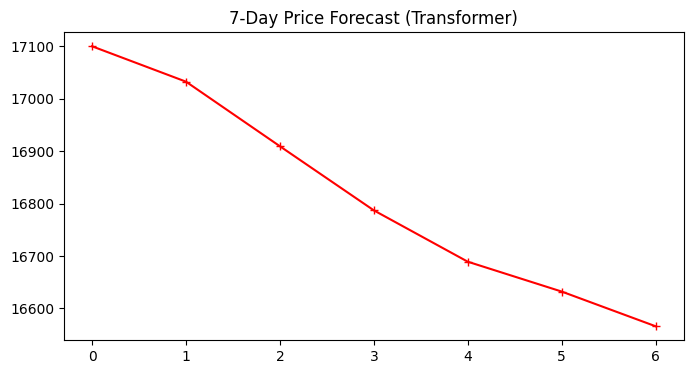

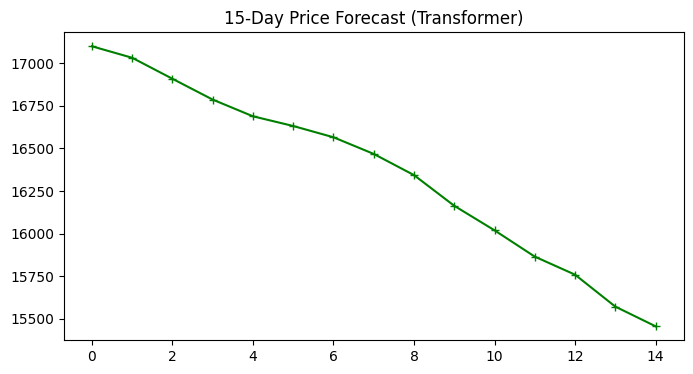

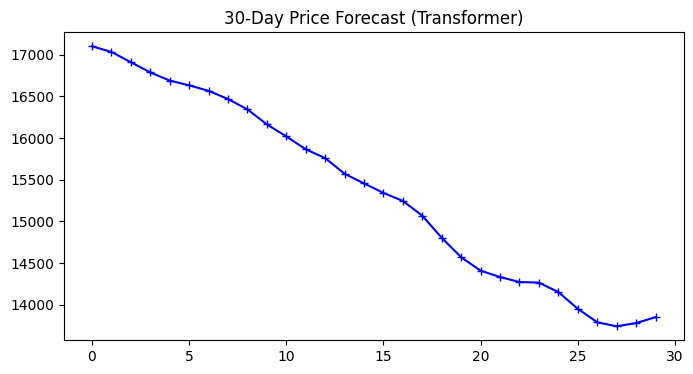

In [159]:
trans_forecast_7  = multi_step_forecast(transformer_model, last_seq, 7)
trans_forecast_15 = multi_step_forecast(transformer_model, last_seq, 15)
trans_forecast_30 = multi_step_forecast(transformer_model, last_seq, 30)
forecast = [trans_forecast_7, trans_forecast_15, trans_forecast_30]
days = [7, 15, 30]
c = ['red','green','blue']
for f, d, color in zip(forecast, days, c):
    plt.figure(figsize=(8,4))
    plt.plot(f, marker='+', color=color)
    plt.title(f"{d}-Day Price Forecast (Transformer)")
    plt.show()


In [ ]:
transformer_model.save("../models/transformer_model.h5")
